# Import the libraries used

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

# plt.style.use('dark_background')

In [2]:
# To comment if you're running on Colab
data_path = Path('Data/')
data_path

WindowsPath('Data')

In [3]:
# To comment if you're running locally
# !git clone https://github.com/FabioLddo/time_series_energy_community_forecasting.git
# data_path = Path('time_series_energy_community_forecasting/Data/')

# Import the data

In [4]:
# Import lic_meteo file
df_meteo = pd.read_pickle(Path(data_path, 'ec_meteo/lic_meteo'))
df_meteo.head()

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.453333,5.613533,-2.768667,0.0,48.806667,0.617600
2020-01-01 00:15:00+00:00,965.460000,5.544867,-2.425200,0.0,49.060000,1.238600
2020-01-01 00:30:00+00:00,965.353333,5.549267,-2.498133,0.0,48.820000,0.854533
2020-01-01 00:45:00+00:00,965.320000,5.639200,-2.406067,0.0,49.093333,0.923733
2020-01-01 01:00:00+00:00,965.300000,6.030800,-2.363267,0.0,47.546667,0.916733


In [5]:
# Import lic_meters file
df_meters = pd.read_pickle(Path(data_path, 'ec_meters/lic_meters'))
df_meters.head()

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   
2020-12-31 23:45:00+00:00   98.0   0.0  291.0   0.0  449.0   0.0  624.0   0.0   
2021-01-01 00:00:00+00:00  131.0   0.0  533.0   0.0  507.0   0.0  547.0   0.0   

                                    4        ...      17           18        \
                                e_pos e_neg  ...   e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...   670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...   525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...   499.0   0.0  436.0   0.0   
2020-12-31 23:45:00+00:00  386.815026   0.0  ...   695.0   0.0  362.0   0.0   
2021-01-01 00:00:00+00:00  390.256124   0.0  ...  1109.0   0.0  504.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  
2020-12-31 23:45:00+00:00   659.0   0.0     1.0   0.0   9380.0   0.0  
2021-01-01 00:00:00+00:00  2384.0   0.0     0.0   0.0  11750.0   0.0  

[5 rows x 44 columns]

In [6]:
# Import lic_nwp file
df_nwp = pd.read_pickle(Path(data_path, 'ec_nwp/lic_nwp'))
df_nwp.head()

ghi_backwards                                        \
                                    0       1       10     100  101  102  103   
2020-01-01 00:00:00+00:00          0.00    0.00  273.43   0.00  0.0  0.0  0.0   
2020-01-01 12:00:00+00:00        354.10  314.48    0.00  33.83  0.0  0.0  0.0   
2020-01-02 00:00:00+00:00          0.00    0.00  265.03   0.00  0.0  0.0  0.0   
2020-01-02 12:00:00+00:00        345.37  307.64    0.00  34.66  0.0  0.0  0.0   
2020-01-03 00:00:00+00:00          0.00    0.00   60.56   0.00  0.0  0.0  0.0   

                                                  ... temperature              \
                             104     105     106  ...         90    91    92    
2020-01-01 00:00:00+00:00  26.58  127.41  234.86  ...        5.27  4.30  3.57   
2020-01-01 12:00:00+00:00   0.00    0.00    0.00  ...        0.44  1.49  2.98   
2020-01-02 00:00:00+00:00  25.69  124.16  229.88  ...        3.81  2.69  1.60   
2020-01-02 12:00:00+00:00   0.00    0.00    0.00  ...        0.83  1.70  2.81   
2020-01-03 00:00:00+00:00  25.68  121.78  221.89  ...        2.87  2.05  1.34   

                                                                     
                            93    94    95    96    97    98    99   
2020-01-01 00:00:00+00:00  3.00  2.57  2.21  1.88  1.59  1.32  1.08  
2020-01-01 12:00:00+00:00  4.72  6.54  8.30  9.51  9.81  9.15  7.88  
2020-01-02 00:00:00+00:00  0.62 -0.21 -0.31 -0.11  0.37  0.50  0.67  
2020-01-02 12:00:00+00:00  4.09  5.42  6.75  7.58  7.72  7.12  6.15  
2020-01-03 00:00:00+00:00  0.72  0.24 -0.08 -0.26 -0.26 -0.15  0.06  

[5 rows x 507 columns]

Check columns of the 3 datasets

In [7]:
# Check df_meteo columns
df_meteo.columns

Index(['AirPressure', 'AirTemp_Avg', 'PyrIrradiance_Avg', 'Ramount_Tot',
       'RelHumidity', 'WindSpeed'],
      dtype='object')

In [8]:
# Check df_meters columns
df_meters.columns

MultiIndex([(        0, 'e_pos'),
            (        0, 'e_neg'),
            (        1, 'e_pos'),
            (        1, 'e_neg'),
            (        2, 'e_pos'),
            (        2, 'e_neg'),
            (        3, 'e_pos'),
            (        3, 'e_neg'),
            (        4, 'e_pos'),
            (        4, 'e_neg'),
            (        5, 'e_pos'),
            (        5, 'e_neg'),
            (        6, 'e_pos'),
            (        6, 'e_neg'),
            (        7, 'e_pos'),
            (        7, 'e_neg'),
            (        8, 'e_pos'),
            (        8, 'e_neg'),
            (        9, 'e_pos'),
            (        9, 'e_neg'),
            (       10, 'e_pos'),
            (       10, 'e_neg'),
            (       11, 'e_pos'),
            (       11, 'e_neg'),
            (       12, 'e_pos'),
            (       12, 'e_neg'),
            (       13, 'e_pos'),
            (       13, 'e_neg'),
            (       14, 'e_pos'),
            ( 

In [9]:
# Check df_nwp columns
df_nwp.columns

MultiIndex([('ghi_backwards',   0),
            ('ghi_backwards',   1),
            ('ghi_backwards',  10),
            ('ghi_backwards', 100),
            ('ghi_backwards', 101),
            ('ghi_backwards', 102),
            ('ghi_backwards', 103),
            ('ghi_backwards', 104),
            ('ghi_backwards', 105),
            ('ghi_backwards', 106),
            ...
            (  'temperature',  90),
            (  'temperature',  91),
            (  'temperature',  92),
            (  'temperature',  93),
            (  'temperature',  94),
            (  'temperature',  95),
            (  'temperature',  96),
            (  'temperature',  97),
            (  'temperature',  98),
            (  'temperature',  99)],
           length=507)

# Exploratory Data Analysis

Visualize the data in df_meteo

<AxesSubplot: >

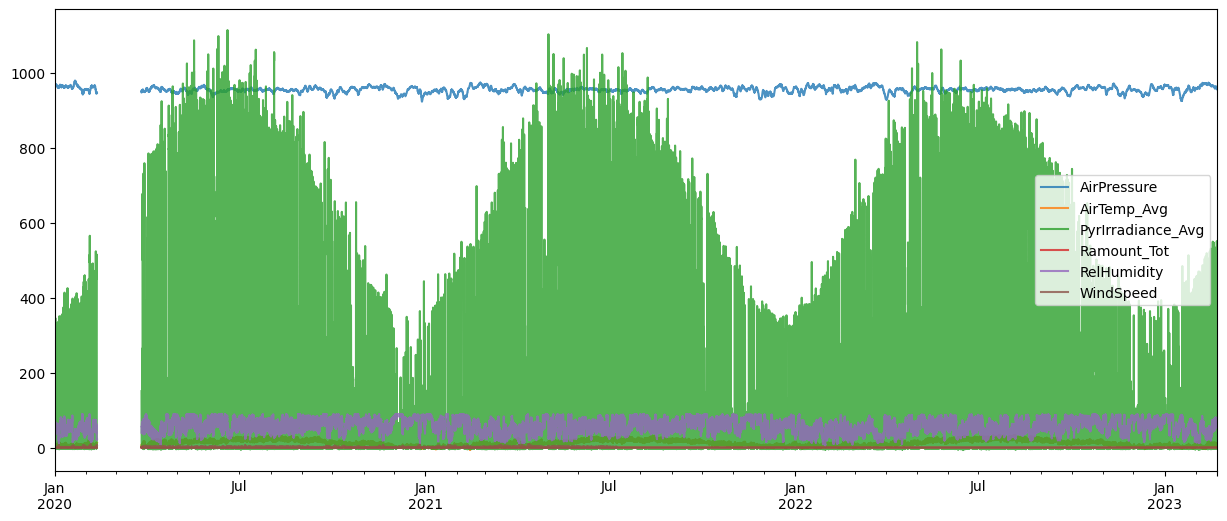

In [10]:
df_meteo.plot(figsize=(15, 6), alpha=0.8)

Visualize the data in df_meters

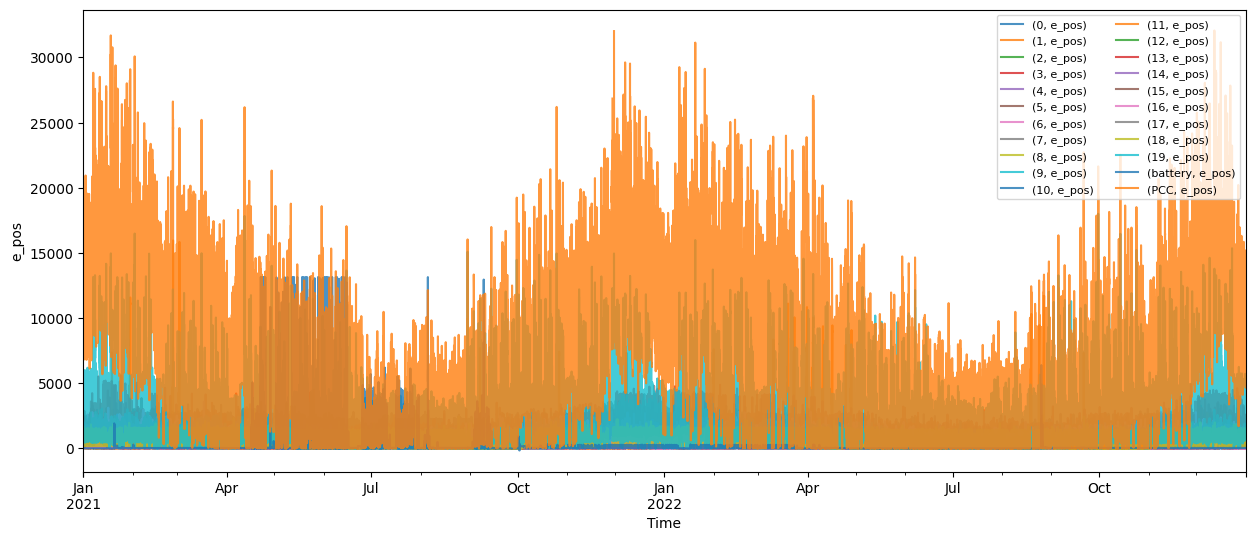

In [11]:
# Plot the e_pos measure in the df_meters dataset
e_pos_cols = [col for col in df_meters.columns if 'e_pos' in col]

# Plot the e_pos columns against the DataFrame's index
df_meters[e_pos_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

df_meters_old = df_meters.copy()  # Save for later

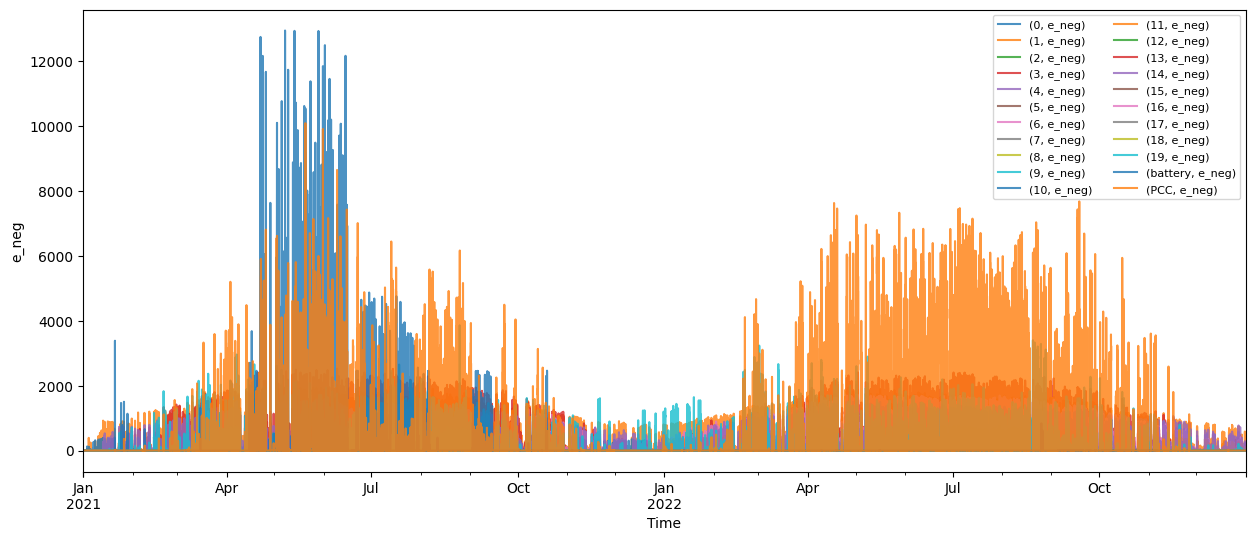

In [12]:
# Plot the e_neg measure in the df_meters dataset
e_neg_cols = [col for col in df_meters.columns if 'e_neg' in col]

# Plot the e_neg columns against the DataFrame's index
df_meters[e_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

Visualize the data in df_nwp

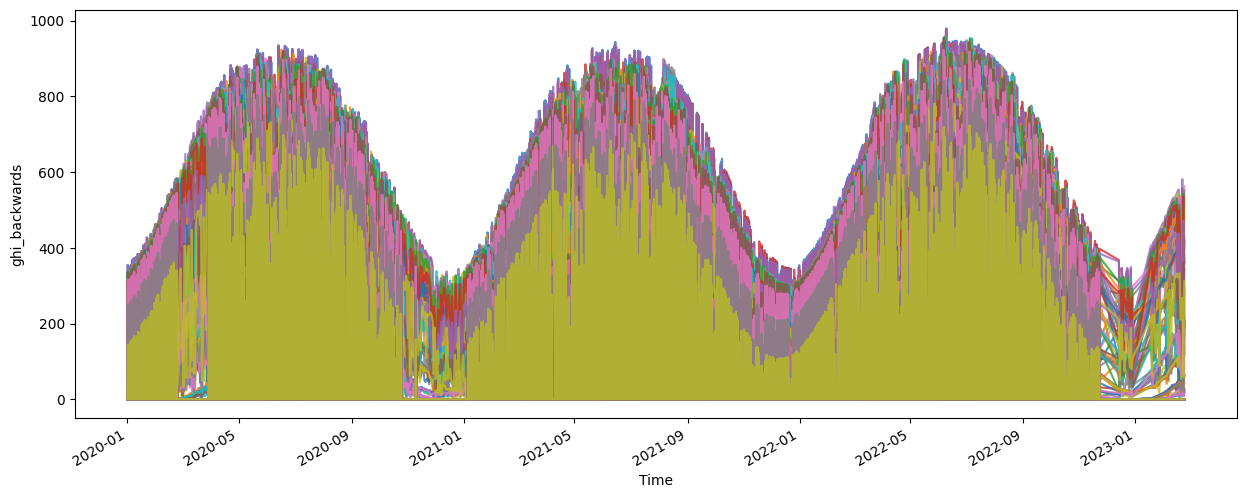

In [13]:
# Plot the ghi_backwards measure in the df_nwp dataset
e_ghi_cols = [col for col in df_nwp.columns if 'ghi_backwards' in col]

# Plot the ghi_backwards columns against the DataFrame's index
df_nwp[e_ghi_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('ghi_backwards')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

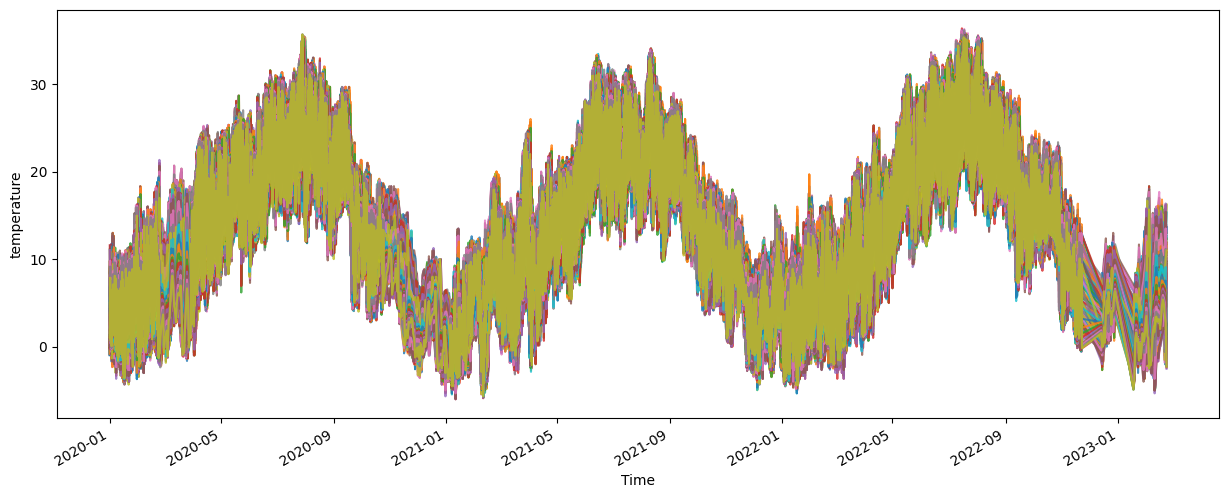

In [14]:
# Plot the temperature measure in the df_nwp dataset
e_temp_cols = [col for col in df_nwp.columns if 'temperature' in col]

# Plot the temperature columns against the DataFrame's index
df_nwp[e_temp_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('temperature')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

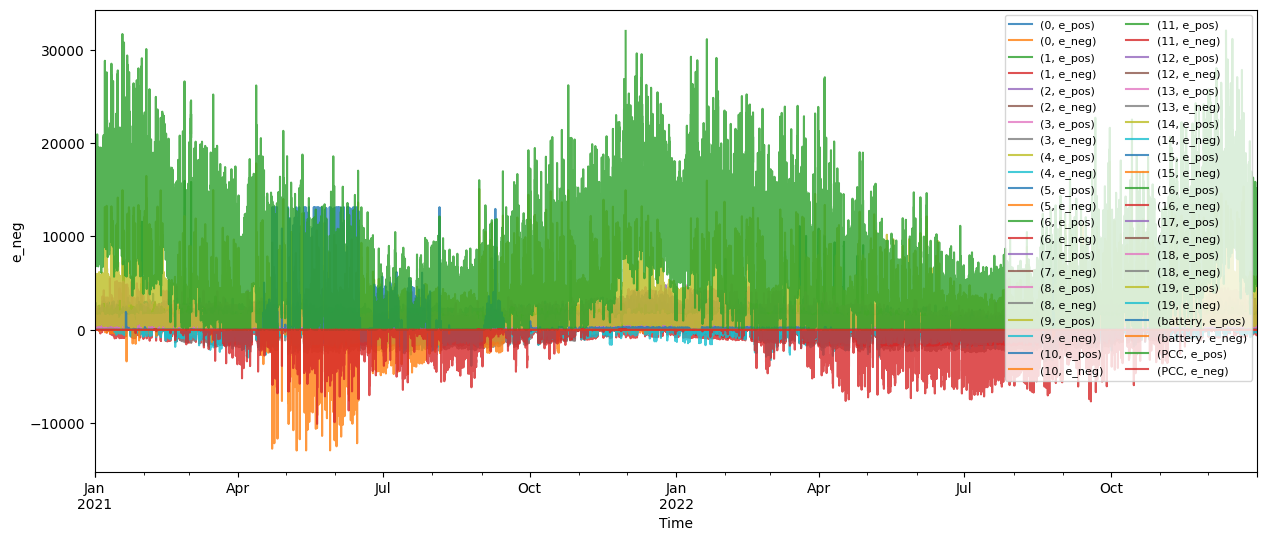

In [15]:
df = df_meters.copy()
df[e_neg_cols] = -df[e_neg_cols]

df.plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

# Clean the data

Comments on the data after having explored it:
- It is requested to resample the data at hourly rate
- It is requested to sum-up the battery data to the PCC data as the energy stored in the battery, as there is a discrepancy with the meters data.

In [16]:
# Check for missing values
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 1269 
---------

df_meteo:
 26022 
---------

df_nwp:
 0 
---------



In [17]:
# Check the shapes of the datasets
print('df_meters:\n', df_meters.shape, '\n---------\n')

print('df_meteo:\n', df_meteo.shape, '\n---------\n')

print('df_nwp:\n', df_nwp.shape, '\n---------\n')

df_meters:
 (70080, 44) 
---------

df_meteo:
 (110208, 6) 
---------

df_nwp:
 (2024, 507) 
---------



## Visualize the position of the missing values

<AxesSubplot: >

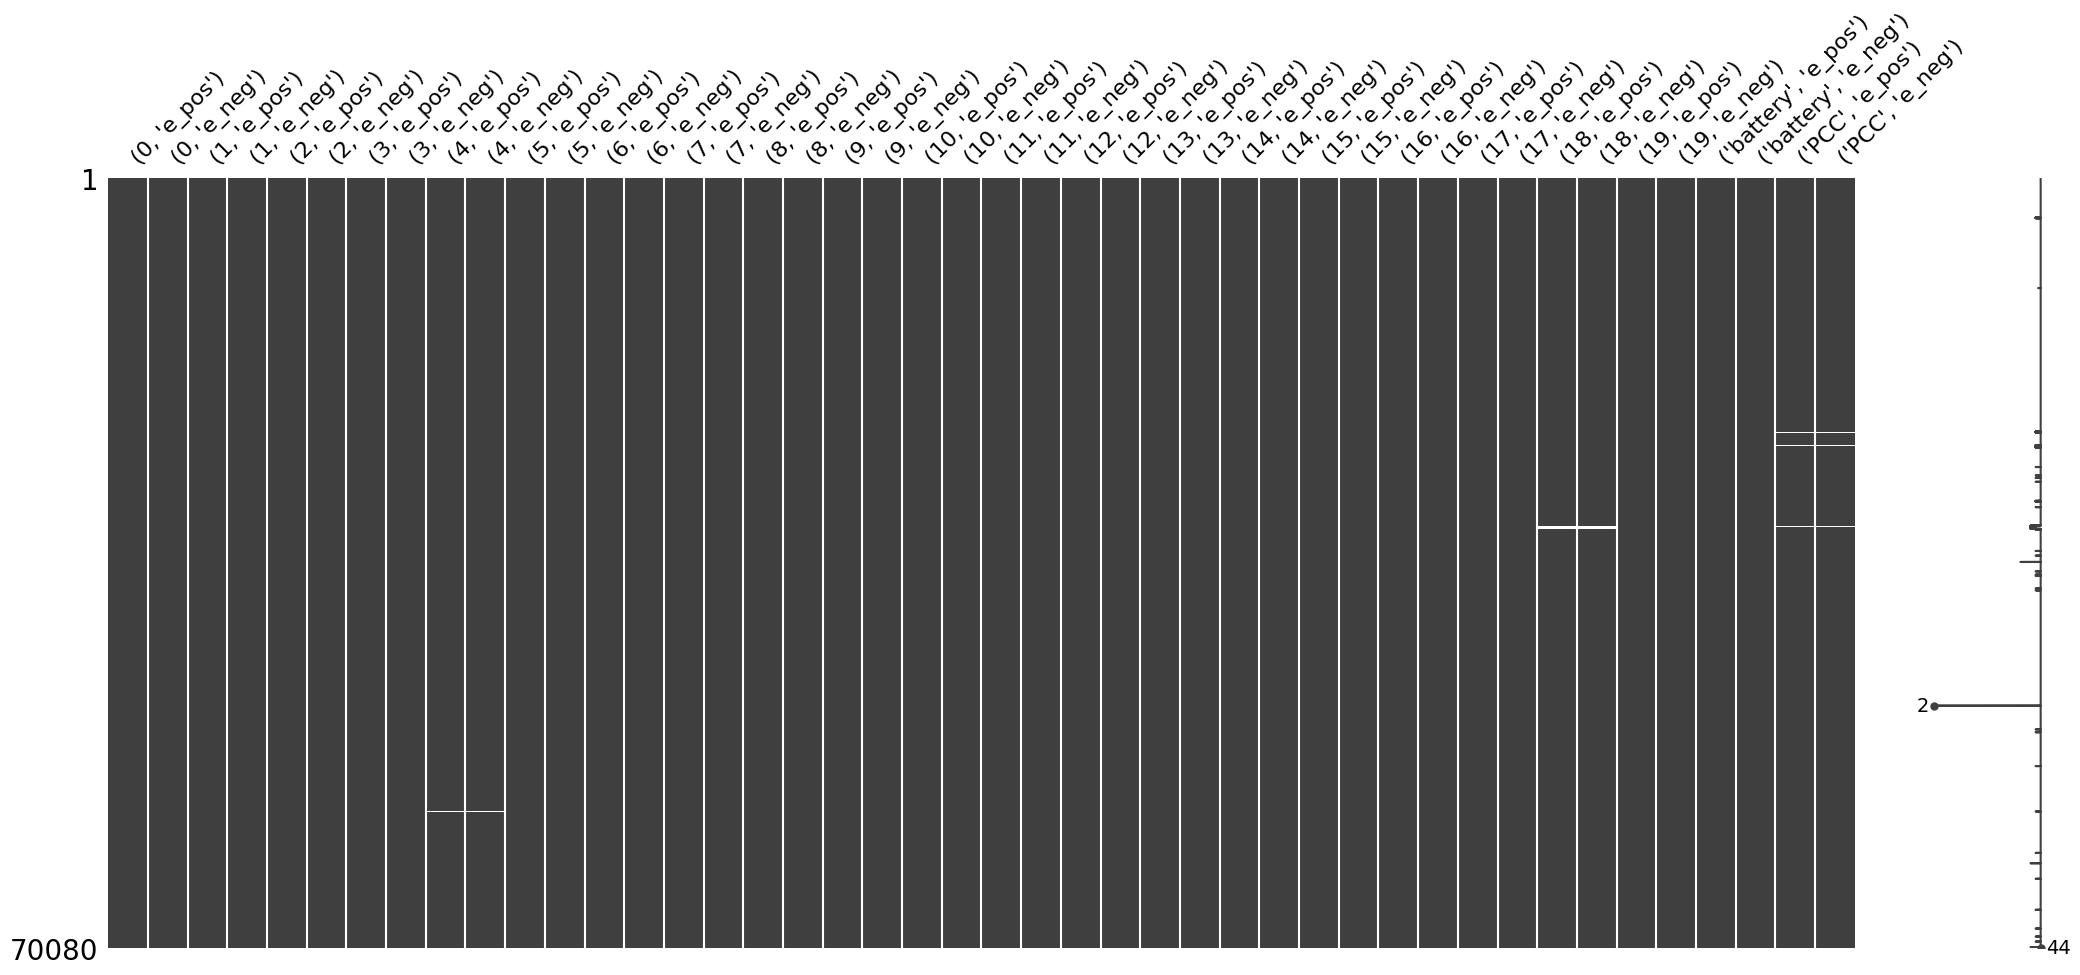

In [18]:
# Visualize the position of null values in the time series of df_meters
msno.matrix(df_meters)

<AxesSubplot: >

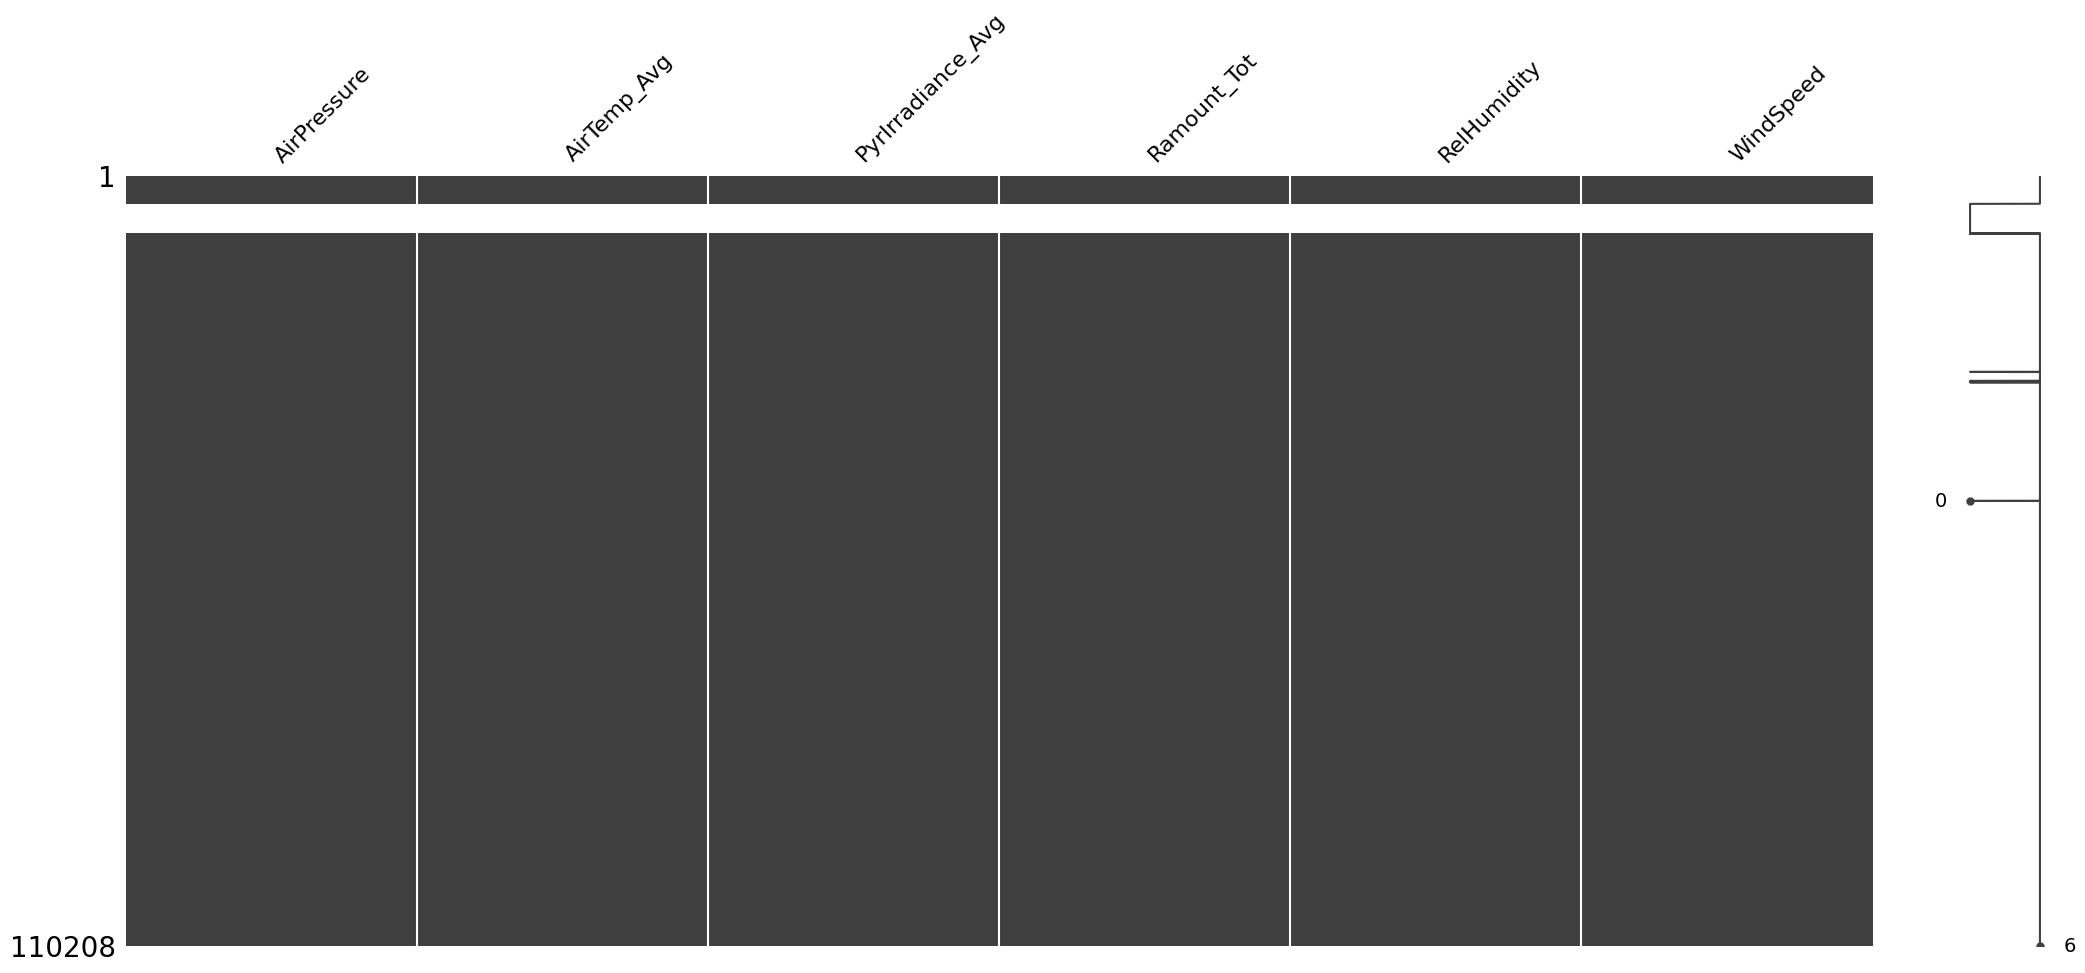

In [19]:
# Visualize the position of null values in the time series of df_meteo
msno.matrix(df_meteo)

<AxesSubplot: >

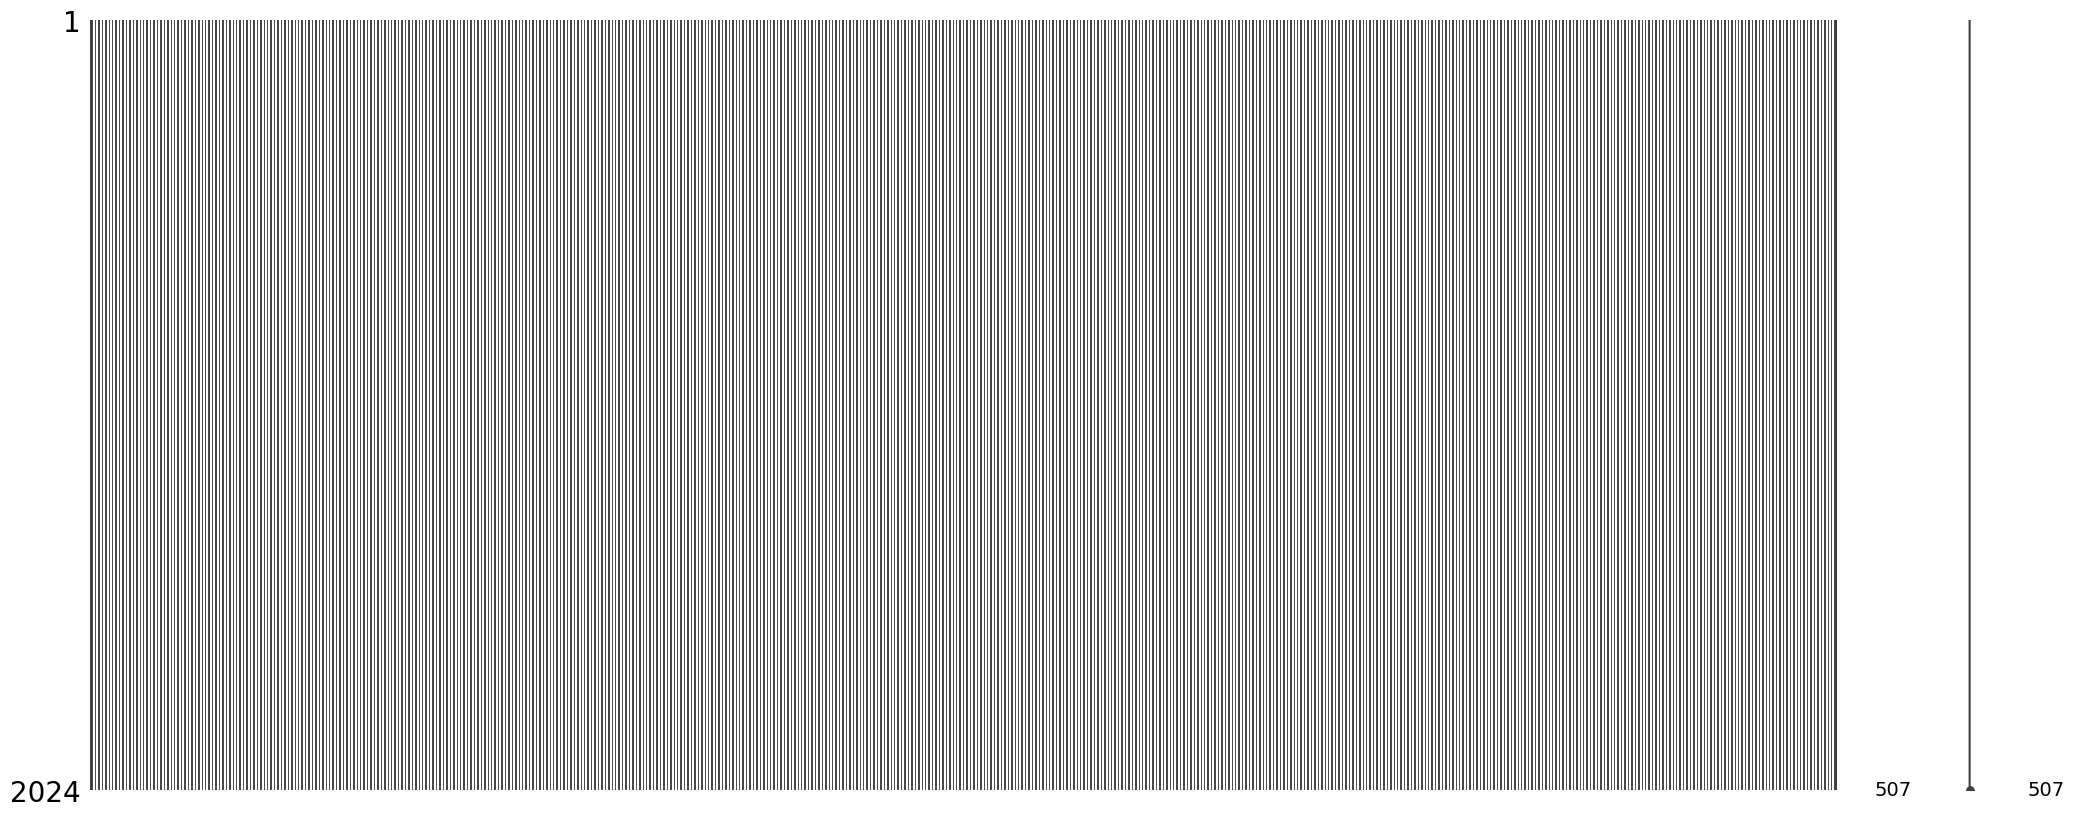

In [20]:
# Visualize the position of null values in the time series of df_nwp
msno.matrix(df_nwp)

## Resample the data at hourly rate

In [21]:
# Check data sampled at 15 minutes intervals in df_meteo
df_meteo.head(3)

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.453333,5.613533,-2.768667,0.0,48.806667,0.617600
2020-01-01 00:15:00+00:00,965.460000,5.544867,-2.425200,0.0,49.060000,1.238600
2020-01-01 00:30:00+00:00,965.353333,5.549267,-2.498133,0.0,48.820000,0.854533


In [22]:
# Check data sampled at 15 minutes intervals in df_meters
df_meters.head(3)

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   

                                    4        ...     17           18        \
                                e_pos e_neg  ...  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...  670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...  525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...  499.0   0.0  436.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  

[3 rows x 44 columns]

In [23]:
# Resample the data at hourly rate
df_meteo = df_meteo.resample('H').mean()  # Get average meteo values at hourly rate
df_meters = df_meters.resample('H').sum()  # Sum the measurements of meters to get hourly values
# df_nwp = df_nwp.resample('H').interpolate(method='linear')  # Interpolate prediction values to get hourly values

In [24]:
# Check data sampled at 1 hour intervals in df_meeto
df_meteo.head(3)

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.396667,5.586717,-2.524517,0.0,48.945000,0.908617
2020-01-01 01:00:00+00:00,965.388333,5.911933,-2.392700,0.0,47.821667,0.877183
2020-01-01 02:00:00+00:00,965.216667,6.480783,-2.452333,0.0,45.773333,1.068467


In [25]:
# Check data sampled at 1 hour intervals in df_meters
df_meters.head(3)

0             1             2             3  \
                           e_pos e_neg   e_pos e_neg   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00  447.0   0.0  1686.0   0.0  1721.0   0.0  2509.0   
2021-01-01 00:00:00+00:00  485.0   0.0   810.0   0.0  1862.0   0.0  2469.0   
2021-01-01 01:00:00+00:00  218.0   0.0  1433.0   0.0  1679.0   0.0  2330.0   

                                           4        ...      17            18  \
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00   0.0  1628.982403   0.0  ...  2389.0   0.0  2119.0   
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  3317.0   0.0  1984.0   
2021-01-01 01:00:00+00:00   0.0  1317.436378   0.0  ...  3390.0   0.0  1639.0   

                                     19       battery            PCC        
                          e_neg   e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00   0.0  6427.0   0.0     3.0   0.0  40947.0   0.0  
2021-01-01 00:00:00+00:00   0.0  6266.0   0.0     2.0   0.0  37873.0   0.0  
2021-01-01 01:00:00+00:00   0.0  7146.0   0.0     3.0   0.0  40145.0   0.0  

[3 rows x 44 columns]

In [26]:
# We slice the data from '2020-12-31 23:00:00+00:00' to '2022-11-28 22:00:00+00:00' so that we have full data fro all the datasets
start_date = '2021-01-01 00:00:00+00:00'

end_date = '2022-11-28 22:00:00+00:00'

df_meteo = df_meteo.loc[start_date:end_date]
df_meters= df_meters.loc[start_date:end_date]
df_nwp = df_nwp.loc[start_date:end_date]

# sort the columns in the multiindex
sorted_nwp = df_nwp.sort_index(axis=1, level=[0, 1])

In [27]:
sorted_nwp.head(3)

ghi_backwards                                     \
                                    0    1    2    3    4    5    6    7     
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-02 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-03 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                         ... temperature                    \
                             8      9    ...         159   160   161   162   
2021-01-01 00:00:00+00:00  13.60  45.82  ...        3.91  2.65  1.47  0.46   
2021-01-02 00:00:00+00:00  12.95  54.19  ...        2.79  1.40  0.20 -0.97   
2021-01-03 00:00:00+00:00   6.86   5.70  ...        3.67  2.91  2.34  1.89   

                                                               
                            163   164   165   166   167   168  
2021-01-01 00:00:00+00:00 -0.31 -0.74 -0.97 -1.27 -1.62 -1.85  
2021-01-02 00:00:00+00:00 -1.91 -2.71 -3.38 -4.05 -3.93 -3.54  
2021-01-03 00:00:00+00:00  1.57  1.34  1.09  0.76  0.35 -0.24  

[3 rows x 507 columns]

In [28]:
# To have hourly samples in df_nwp we use its predictions for the next hours 

def create_empty_hourly_df(start_date, end_date):
    hourly_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='H'),
                                columns=range(24))
    return hourly_df

def get_hourly(df_preds, df_hourly):
    for i in range(len(df_hourly)):
        time = df_hourly.index[i]
        preds_row = df_preds.loc[df_preds.index <= time].iloc[-1]
        delta = time - preds_row.name  
        hours_diff = delta.total_seconds() / 3600
        df_hourly.iloc[i] = df_preds.loc[df_preds.index <= time].iloc[-1, int(hours_diff):24 + int(hours_diff)].values
    return df_hourly

dfs_list = []
for column in ['ghi_backwards', 'temperature', 'relativehumidity']:
    df = sorted_nwp[column]
    hourly_df = create_empty_hourly_df(start_date, end_date)
    hourly_df = get_hourly(df, hourly_df)
    dfs_list.append(hourly_df)

# concatenate the 3 hourly dfs adding the name of the column as level 1 index of the multiindex
hourly_nwp_df = pd.concat(dfs_list, axis=1, keys=['ghi_backwards', 'temperature', 'relativehumidity'])


In [29]:
df_nwp = hourly_nwp_df
df_nwp

ghi_backwards                                     \
                                     0    1    2    3     4      5      6    
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2021-01-01 01:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2021-01-01 02:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0   13.6   
2021-01-01 03:00:00+00:00           0.0  0.0  0.0  0.0   0.0   13.6  45.82   
2021-01-01 04:00:00+00:00           0.0  0.0  0.0  0.0  13.6  45.82  72.37   
...                                 ...  ...  ...  ...   ...    ...    ...   
2022-11-28 18:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 19:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 20:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 21:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 22:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   

                                                ... relativehumidity         \
                              7      8      9   ...               14     15   
2021-01-01 00:00:00+00:00    0.0   13.6  45.82  ...             87.0   92.0   
2021-01-01 01:00:00+00:00   13.6  45.82  72.37  ...             92.0   98.0   
2021-01-01 02:00:00+00:00  45.82  72.37  59.97  ...             98.0  100.0   
2021-01-01 03:00:00+00:00  72.37  59.97  61.64  ...            100.0   99.0   
2021-01-01 04:00:00+00:00  59.97  61.64  75.82  ...             99.0  100.0   
...                          ...    ...    ...  ...              ...    ...   
2022-11-28 18:00:00+00:00    0.0    0.0    0.0  ...             89.0   79.0   
2022-11-28 19:00:00+00:00    0.0    0.0    0.0  ...             79.0   71.0   
2022-11-28 20:00:00+00:00    0.0    0.0    0.0  ...             71.0   65.0   
2022-11-28 21:00:00+00:00    0.0    0.0    0.0  ...             65.0   61.0   
2022-11-28 22:00:00+00:00    0.0    0.0   1.85  ...             61.0   60.0   

                                                                            \
                              16     17     18     19     20     21     22   
2021-01-01 00:00:00+00:00   98.0  100.0   99.0  100.0  100.0  100.0   99.0   
2021-01-01 01:00:00+00:00  100.0   99.0  100.0  100.0  100.0   99.0  100.0   
2021-01-01 02:00:00+00:00   99.0  100.0  100.0  100.0   99.0  100.0  100.0   
2021-01-01 03:00:00+00:00  100.0  100.0  100.0   99.0  100.0  100.0  100.0   
2021-01-01 04:00:00+00:00  100.0  100.0   99.0  100.0  100.0  100.0  100.0   
...                          ...    ...    ...    ...    ...    ...    ...   
2022-11-28 18:00:00+00:00   71.0   65.0   61.0   60.0   64.0   72.0   80.0   
2022-11-28 19:00:00+00:00   65.0   61.0   60.0   64.0   72.0   80.0   85.0   
2022-11-28 20:00:00+00:00   61.0   60.0   64.0   72.0   80.0   85.0   86.0   
2022-11-28 21:00:00+00:00   60.0   64.0   72.0   80.0   85.0   86.0   87.0   
2022-11-28 22:00:00+00:00   64.0   72.0   80.0   85.0   86.0   87.0   87.0   

                                  
                              23  
2021-01-01 00:00:00+00:00  100.0  
2021-01-01 01:00:00+00:00  100.0  
2021-01-01 02:00:00+00:00  100.0  
2021-01-01 03:00:00+00:00  100.0  
2021-01-01 04:00:00+00:00  100.0  
...                          ...  
2022-11-28 18:00:00+00:00   85.0  
2022-11-28 19:00:00+00:00   86.0  
2022-11-28 20:00:00+00:00   87.0  
2022-11-28 21:00:00+00:00   87.0  
2022-11-28 22:00:00+00:00   86.0  

[16727 rows x 72 columns]

## Sum up the battery data to the PCC data

We had to do it because it happens that sometimes the battery starts storing and providing energy to the stations

In [30]:
# Check PCC data
df_meters['PCC'].head(3)

,e_pos,e_neg
2021-01-01 00:00:00+00:00,37873.0,0.0
2021-01-01 01:00:00+00:00,40145.0,0.0
2021-01-01 02:00:00+00:00,35965.0,0.0


In [31]:
# Check battery data
df_meters['battery'].head(3)

,e_pos,e_neg
2021-01-01 00:00:00+00:00,2.0,0.0
2021-01-01 01:00:00+00:00,3.0,0.0
2021-01-01 02:00:00+00:00,2.0,0.0


In [32]:
# Duplicate the column PCC to then sum it up with the battery data
new_columns = pd.DataFrame(df_meters['PCC'].values, index=df_meters['PCC'].index, 
                           columns=[('PCC_batt', 'e_pos'), ('PCC_batt', 'e_neg')])
df_meters = pd.concat([df_meters, new_columns], axis=1)

In [33]:
# Check if the new 'PCC_batt' column was added
df_meters.columns[-5]

('battery', 'e_neg')

In [34]:
# Fortunately the data is aligned, so we can simply sum the features
# Sum up battery and PCC data
df_meters[('PCC_batt', 'e_pos')] += df_meters[('battery', 'e_pos')]
df_meters[('PCC_batt', 'e_neg')] += df_meters[('battery', 'e_neg')]

In [35]:
 # Check that the sum was successful
df_meters[['PCC', 'battery', 'PCC_batt']].head(3)

# We'll keep the old columns 'PCC' and 'battery' in case we'll need them later

PCC       battery       PCC_batt      
                             e_pos e_neg   e_pos e_neg    e_pos e_neg
2021-01-01 00:00:00+00:00  37873.0   0.0     2.0   0.0  37875.0   0.0
2021-01-01 01:00:00+00:00  40145.0   0.0     3.0   0.0  40148.0   0.0
2021-01-01 02:00:00+00:00  35965.0   0.0     2.0   0.0  35967.0   0.0

## Impute the missing values on df_meters

In [36]:
# Check for nulls in the datasets
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 0 
---------

df_meteo:
 0 
---------

df_nwp:
 0 
---------



<AxesSubplot: >

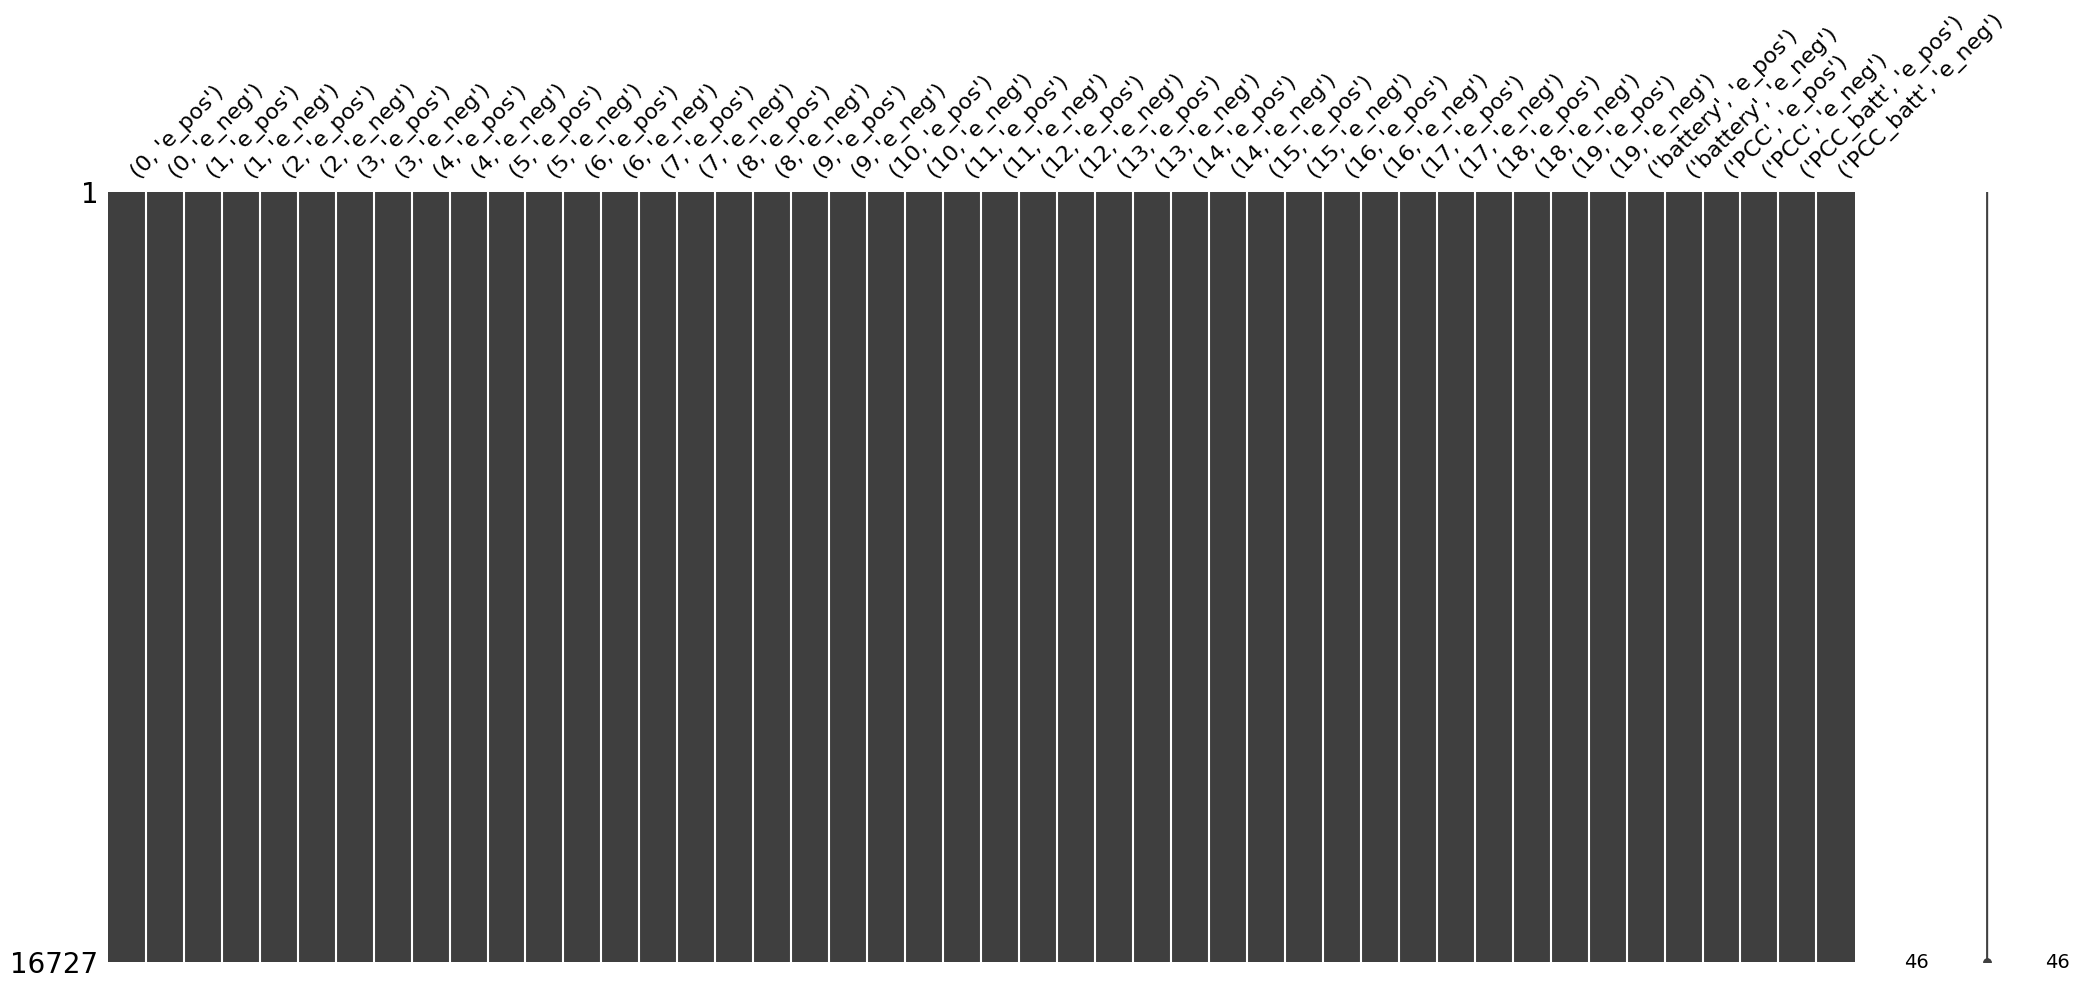

In [37]:
# Visualize the position of the missing values 
msno.matrix(df_meters)

In [38]:
# Impute missing values with the mean
print('Nulls before numerical features imputation:', df_meters.isna().sum().sum())

df_meters = df_meters.fillna(df_meters.mean())

print('Nulls after numerical features imputation:', df_meters.isna().sum().sum())

Nulls before numerical features imputation: 0
Nulls after numerical features imputation: 0


## Remove the multi index

It is not very intuitive to work with a multi-index dataframe, so we'll convert it to a single index dataframe

In [39]:
# Check initial state of df_meters
df_meters.head(1)

0            1             2             3  \
                           e_pos e_neg  e_pos e_neg   e_pos e_neg   e_pos   
2021-01-01 00:00:00+00:00  485.0   0.0  810.0   0.0  1862.0   0.0  2469.0   

                                           4        ...      18            19  \
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  1984.0   0.0  6266.0   

                                battery            PCC       PCC_batt        
                          e_neg   e_pos e_neg    e_pos e_neg    e_pos e_neg  
2021-01-01 00:00:00+00:00   0.0     2.0   0.0  37873.0   0.0  37875.0   0.0  

[1 rows x 46 columns]

In [40]:
# Check initial state of df_nwp
df_nwp.head(1)

ghi_backwards                                     \
                                     0    1    2    3    4    5    6    7    
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                        ... relativehumidity              \
                             8      9   ...               14    15    16   
2021-01-01 00:00:00+00:00  13.6  45.82  ...             87.0  92.0  98.0   

                                                                          
                              17    18     19     20     21    22     23  
2021-01-01 00:00:00+00:00  100.0  99.0  100.0  100.0  100.0  99.0  100.0  

[1 rows x 72 columns]

In [41]:
# Remove the multi index from df_meters and df_nwp
# df_meteo already has no multi index
df_meters_multi = df_meters
df_meters.columns = [f'{col[1]}_{col[0]}' for col in df_meters.columns]
df_nwp.columns = [f'{col[1]}_{col[0]}' for col in df_nwp.columns]

In [42]:
# Check result on df_meters
df_meters.head(1)

,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,e_neg_4,...,e_pos_18,e_neg_18,e_pos_19,e_neg_19,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,e_pos_PCC_batt,e_neg_PCC_batt
2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,0.0,...,1984.0,0.0,6266.0,0.0,2.0,0.0,37873.0,0.0,37875.0,0.0


In [43]:
# Check result on df_nwp
df_nwp.head(1)

,0_ghi_backwards,1_ghi_backwards,2_ghi_backwards,3_ghi_backwards,4_ghi_backwards,5_ghi_backwards,6_ghi_backwards,7_ghi_backwards,8_ghi_backwards,9_ghi_backwards,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
2021-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.6,45.82,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0


## Merge the datasets to get a single dataset with all the features
Some data has different time windows, so there will be some NaN values.
We decided to drop the windows where we don't have data from all the features.

In [44]:
# Check the range of dates in the three datasets
print('Start date:\n',
      'df_meters:', df_meters.index.min(), '\n',
      'df_meteo:', df_meteo.index.min(), '\n',
      'df_nwp:', df_nwp.index.min(), '\n')
      
print('End date:\n',
      'df_meters:', df_meters.index.max(), '\n',
      'df_meteo:', df_meteo.index.max(), '\n',
      'df_nwp:', df_nwp.index.max())

Start date:
 df_meters: 2021-01-01 00:00:00+00:00 
 df_meteo: 2021-01-01 00:00:00+00:00 
 df_nwp: 2021-01-01 00:00:00+00:00 

End date:
 df_meters: 2022-11-28 22:00:00+00:00 
 df_meteo: 2022-11-28 22:00:00+00:00 
 df_nwp: 2022-11-28 22:00:00+00:00


In [45]:
df = pd.concat([df_meters, df_meteo, df_nwp], axis=1)

In [46]:
df.shape

(16727, 124)

In [47]:
df.head(3)

,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,e_neg_4,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,0.0,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,0.0,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,0.0,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


## Sum up the data about station 10 and 11

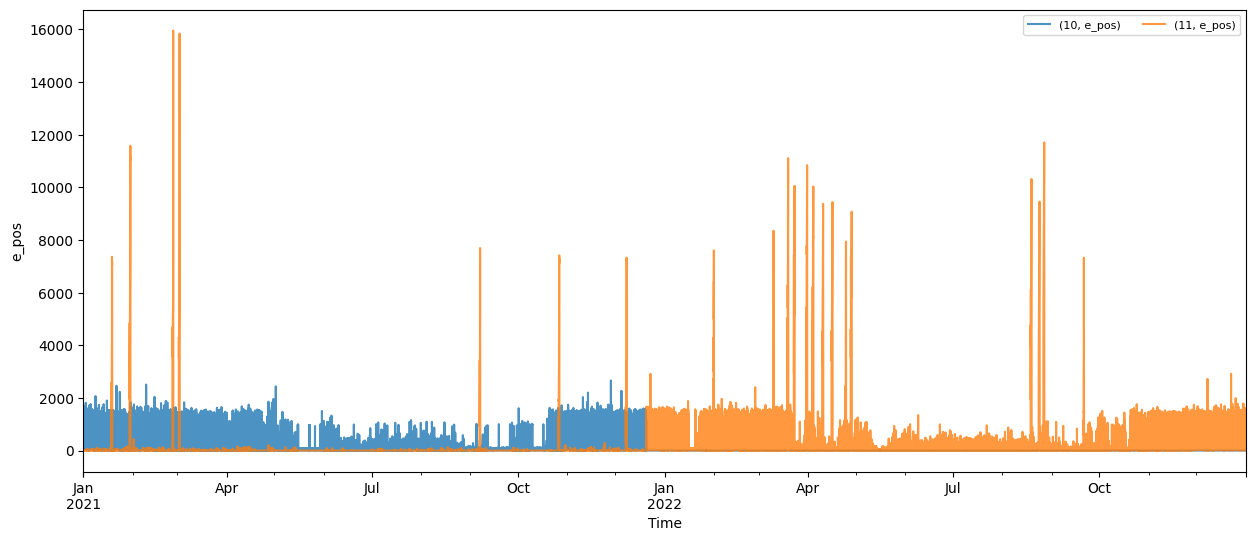

In [48]:
# The data in station 10 and 11 seem to be from the same source/people who changed station, so we'll sum them up
df_meters_old[e_pos_cols[10:12]].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

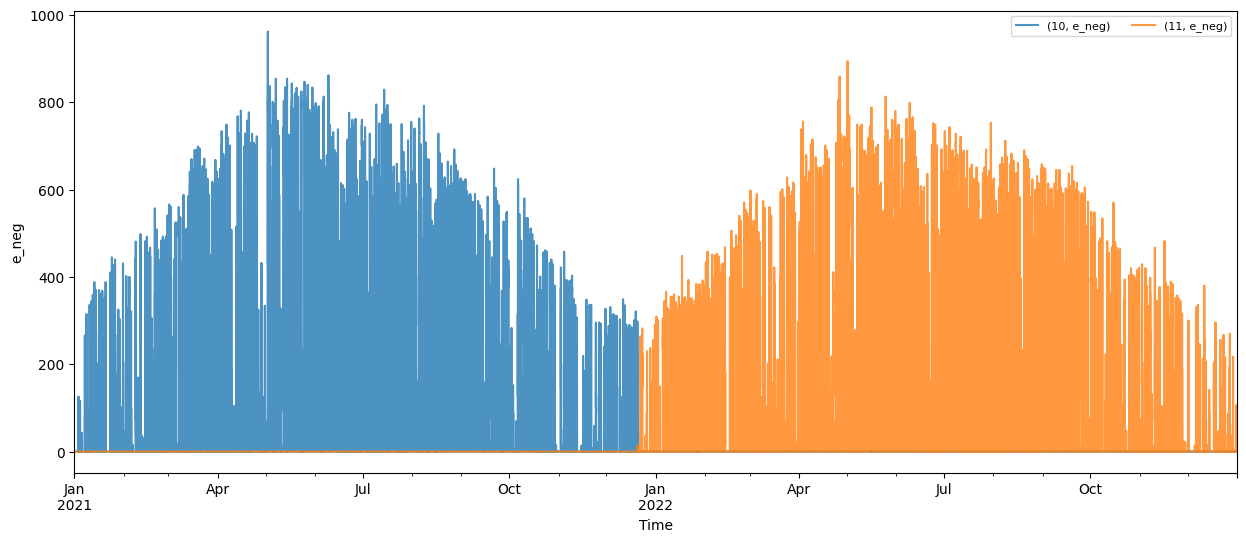

In [49]:
df_meters_old[e_neg_cols[10:12]].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [50]:
# Identify the date in which the two stations were swapped
trial_pos = df_meters_old[e_pos_cols[10:12]]
trial_neg = df_meters_old[e_neg_cols[10:12]]

In [51]:
trial_pos = trial_pos.reset_index()
trial_neg = trial_neg.reset_index()

In [52]:
# Get the number of samples in december 2021
trial_pos[(trial_pos['index'] >= '2021-12-01') & (trial_pos['index'] < '2022-01-01')].shape

(2976, 3)

In [53]:
# Inspect e_pos values in december 2021
trial_pos[(trial_pos['index'] >= '2021-12-01') & (trial_pos['index'] < '2022-01-01')][1870:1885]

,index,10,11
,,e_pos,e_pos
33938,2021-12-20 11:30:00+00:00,0.0,0.0
33939,2021-12-20 11:45:00+00:00,0.0,0.0
33940,2021-12-20 12:00:00+00:00,0.0,0.0
33941,2021-12-20 12:15:00+00:00,0.0,0.0
33942,2021-12-20 12:30:00+00:00,6.0,0.0
33943,2021-12-20 12:45:00+00:00,0.0,0.0
33944,2021-12-20 13:00:00+00:00,0.0,NaN
33945,2021-12-20 13:15:00+00:00,0.0,NaN
33946,2021-12-20 13:30:00+00:00,0.0,NaN


In [54]:
# Inspect e_neg values in december 2021
trial_neg[(trial_neg['index'] >= '2021-12-01') & (trial_neg['index'] < '2022-01-01')][1870:1885]

,index,10,11
,,e_neg,e_neg
33938,2021-12-20 11:30:00+00:00,290.0,0.0
33939,2021-12-20 11:45:00+00:00,298.0,0.0
33940,2021-12-20 12:00:00+00:00,288.0,0.0
33941,2021-12-20 12:15:00+00:00,275.0,0.0
33942,2021-12-20 12:30:00+00:00,238.0,0.0
33943,2021-12-20 12:45:00+00:00,211.0,0.0
33944,2021-12-20 13:00:00+00:00,0.0,NaN
33945,2021-12-20 13:15:00+00:00,0.0,NaN
33946,2021-12-20 13:30:00+00:00,0.0,NaN


In [55]:
# The switch happens in the days around '2021-12-20 13:00:00+00:00'

# Add Date column to the dataframe
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])

# Set e_pos_10 and e_neg_10 to 0 when Date > '2021-12-20 13:00:00+00:00'
df.loc[df['Date'] > pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_10', 'e_neg_10']] = 0

# Set e_pos_11 and e_neg_11 to 0 when Date < '2021-12-20 13:00:00+00:00'
df.loc[df['Date'] < pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_11', 'e_neg_11']] = 0

# Adjust the dataset
df['e_neg_10'] = df['e_neg_11']
df['e_pos_10'] = df['e_pos_11']
df =df.drop(columns=['e_pos_11', 'e_neg_11'])
for i in range(12, 20):
    df = df.rename(columns={
        f"e_pos_{i}": f"e_pos_{i-1}",
        f"e_neg_{i}": f"e_neg_{i-1}",
    })


df.head(3)

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0


In [56]:
# Do the same on just df_meters because we need it to perform other tasks
# Add Date column to the dataframe
df_meters.reset_index(inplace=True)
df_meters.rename(columns={'index': 'Date'}, inplace=True)

df_meters['Date'] = pd.to_datetime(df_meters['Date'])

# Set e_pos_10 and e_neg_10 to 0 when Date > '2021-12-20 13:00:00+00:00'
df_meters.loc[df_meters['Date'] > pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_10', 'e_neg_10']] = 0

# Set e_pos_11 and e_neg_11 to 0 when Date < '2021-12-20 13:00:00+00:00'
df_meters.loc[df_meters['Date'] < pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_11', 'e_neg_11']] = 0

# Adjust the dataset
df_meters['e_neg_10'] = df_meters['e_neg_11']
df_meters['e_pos_10'] = df_meters['e_pos_11']
df_meters = df_meters.drop(columns=['e_pos_11', 'e_neg_11'])
for i in range(12, 20):
    df_meters = df_meters.rename(columns={
        f"e_pos_{i}": f"e_pos_{i-1}",
        f"e_neg_{i}": f"e_neg_{i-1}",
    })


df_meters.head(3)

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,e_pos_17,e_neg_17,e_pos_18,e_neg_18,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,e_pos_PCC_batt,e_neg_PCC_batt
0,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,1984.0,0.0,6266.0,0.0,2.0,0.0,37873.0,0.0,37875.0,0.0
1,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,1639.0,0.0,7146.0,0.0,3.0,0.0,40145.0,0.0,40148.0,0.0
2,2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,1421.0,0.0,7299.0,0.0,2.0,0.0,35965.0,0.0,35967.0,0.0


## Get columns e_pos and e_neg containing the concatenatenated values of all the stations

In [57]:
df_new = pd.DataFrame()
df_meters_temp = df_meters.copy()

for i in range(19):
    if i == 0:
        df_new[f'e_pos'] = df_meters_temp[f'e_pos_{i}']
        df_new[f'e_neg'] = df_meters_temp[f'e_neg_{i}']
        df_new['y'] = df_meters_temp[f'e_pos_{i}'] - df_meters_temp[f'e_neg_{i}']
        df_new['unique_id'] = i
        df_new['ds'] = df_meters_temp['Date']
    else:
        df_loop = pd.DataFrame()
        df_loop[f'e_pos'] = df_meters_temp[f'e_pos_{i}']
        df_loop[f'e_neg'] = df_meters_temp[f'e_neg_{i}']
        df_loop['y'] = df_meters_temp[f'e_pos_{i}'] - df_meters_temp[f'e_neg_{i}']
        df_loop['unique_id'] = i
        df_loop['ds'] = df_meters_temp['Date']
        df_new = pd.concat([df_new, df_loop], axis=0)

df_new.reset_index(drop=True, inplace=True)
# df_new[df_new['unique_id'] == 1]
# df_new.unique_id.unique()

e_pos_series = df_new['e_pos']
e_neg_series = df_new['e_neg']

df_new.pop('e_pos')
df_new.pop('e_neg')

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
317808    0.0
317809    0.0
317810    0.0
317811    0.0
317812    0.0
Name: e_neg, Length: 317813, dtype: float64

In [58]:
df

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,14_relativehumidity,15_relativehumidity,16_relativehumidity,17_relativehumidity,18_relativehumidity,19_relativehumidity,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity
0,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,87.0,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0
1,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,92.0,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0
2,2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,98.0,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0
3,2021-01-01 03:00:00+00:00,287.0,0.0,1688.0,0.0,1879.0,0.0,2123.0,0.0,558.000000,...,100.0,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0
4,2021-01-01 04:00:00+00:00,227.0,0.0,1762.0,0.0,1998.0,0.0,4850.0,0.0,522.000000,...,99.0,100.0,100.0,100.0,99.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722,2022-11-28 18:00:00+00:00,262.0,0.0,2515.0,0.0,2251.0,0.0,2948.0,0.0,1903.000000,...,89.0,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0
16723,2022-11-28 19:00:00+00:00,1037.0,0.0,2458.0,0.0,1263.0,0.0,3406.0,0.0,1518.000000,...,79.0,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0
16724,2022-11-28 20:00:00+00:00,948.0,0.0,637.0,0.0,1235.0,0.0,2146.0,0.0,1800.000000,...,71.0,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0
16725,2022-11-28 21:00:00+00:00,215.0,0.0,464.0,0.0,1191.0,0.0,1159.0,0.0,1059.000000,...,65.0,61.0,60.0,64.0,72.0,80.0,85.0,86.0,87.0,87.0


## Add features for the seasonality

In [59]:
# Add features about the date for the seasonality
df['day_of_week'] = df.Date.dt.dayofweek
df['day_of_year'] = df.Date.dt.day_of_year
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['hour'] = df.Date.dt.hour

In [60]:
df.head(2)

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
0,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,100.0,100.0,99.0,100.0,4,1,2021,1,1,0
1,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,100.0,99.0,100.0,100.0,4,1,2021,1,1,1


<Figure size 1500x600 with 0 Axes>

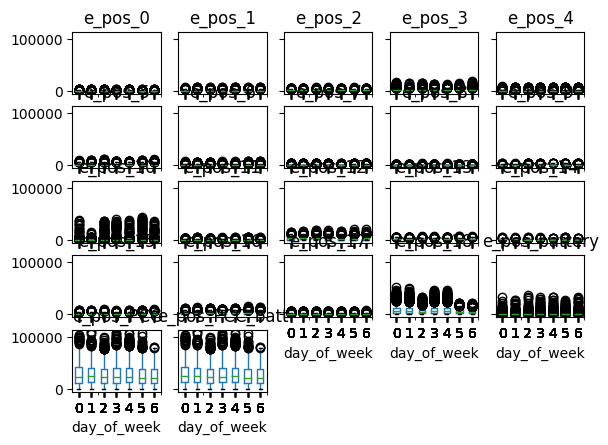

In [61]:
# Create a boxplot of e_pos_neg_sum grouped by the day of the week
e_pos_cols = [col for col in df.columns if 'e_pos' in col]

plt.figure(figsize=(15, 6))
df.boxplot(column=e_pos_cols, by='day_of_week', grid=False)
plt.xlabel('Day of the Week')
plt.ylabel('e_pos')
plt.title('e_pos by day of the week')
plt.xticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.suptitle('')  
plt.show()

<Figure size 1500x600 with 0 Axes>

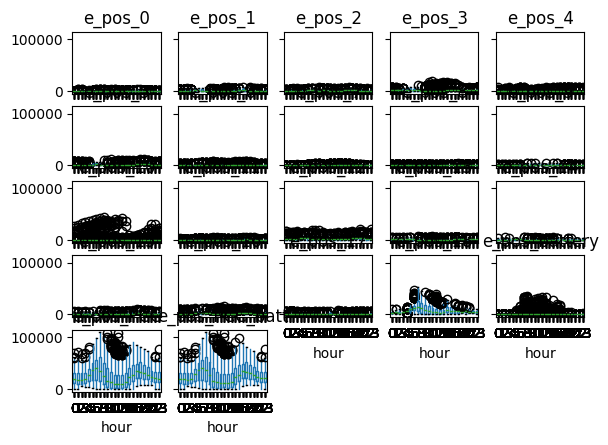

In [62]:
# Create a boxplot of e_pos_neg_sum grouped by the hour of the day
e_pos_cols = [col for col in df.columns if 'e_pos' in col]

plt.figure(figsize=(15, 6))
df.boxplot(column=e_pos_cols, by='hour', grid=False)
plt.xlabel('Hour of the Day')
plt.ylabel('e_pos')
plt.title('e_pos by Hour of the Day')
plt.suptitle('')  
plt.show()

## Drop unused columns andf add useful features

In [63]:
# Add the sum of e_pos and e_neg of PCC_batt
pcc_pos = df.pop('e_pos_PCC_batt')
pcc_neg = df.pop('e_neg_PCC_batt')
pcc_pos_neg_sum = pcc_pos - pcc_neg
# Insert the columns of interest in the first columns after Date
df.insert(1, 'PCC_batt_sum', pcc_pos_neg_sum)

In [64]:
# Save the dataset with no rows columns concatenation and before dropping the columns for each station
df_nc = df.copy() 

In [65]:
# For e_pos and e_neg
for i in range(19):
    e_pos = df_nc.pop(f'e_pos_{i}')
    e_neg = df_nc.pop(f'e_neg_{i}')
    e_pos_neg_sum = e_pos - e_neg
    # Insert the columns of interest in the first columns after Date
    df_nc.insert(1, f'e_pos_neg_sum_{i}', e_pos_neg_sum)
    
df_nc = df_nc.drop(columns=['e_pos_battery', 'e_neg_battery', 'e_pos_PCC', 'e_neg_PCC'])

In [66]:
df_nc

,Date,e_pos_neg_sum_18,e_pos_neg_sum_17,e_pos_neg_sum_16,e_pos_neg_sum_15,e_pos_neg_sum_14,e_pos_neg_sum_13,e_pos_neg_sum_12,e_pos_neg_sum_11,e_pos_neg_sum_10,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
0,2021-01-01 00:00:00+00:00,6266.0,1984.0,3317.0,2976.0,2041.0,1815.0,4644.0,222.0,0.0,...,100.0,100.0,99.0,100.0,4,1,2021,1,1,0
1,2021-01-01 01:00:00+00:00,7146.0,1639.0,3390.0,1224.0,2478.0,2657.0,4191.0,222.0,0.0,...,100.0,99.0,100.0,100.0,4,1,2021,1,1,1
2,2021-01-01 02:00:00+00:00,7299.0,1421.0,3174.0,1663.0,1917.0,2639.0,4148.0,245.0,0.0,...,99.0,100.0,100.0,100.0,4,1,2021,1,1,2
3,2021-01-01 03:00:00+00:00,6286.0,1759.0,4358.0,2940.0,2083.0,1868.0,5002.0,205.0,0.0,...,100.0,100.0,100.0,100.0,4,1,2021,1,1,3
4,2021-01-01 04:00:00+00:00,6120.0,2251.0,2974.0,2775.0,2429.0,3070.0,4152.0,248.0,0.0,...,100.0,100.0,100.0,100.0,4,1,2021,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16722,2022-11-28 18:00:00+00:00,12066.0,1302.0,4575.0,3669.0,1705.0,2850.0,4551.0,3097.0,4664.0,...,64.0,72.0,80.0,85.0,0,332,2022,11,28,18
16723,2022-11-28 19:00:00+00:00,9108.0,716.0,4488.0,2095.0,2306.0,4990.0,6040.0,1889.0,3613.0,...,72.0,80.0,85.0,86.0,0,332,2022,11,28,19
16724,2022-11-28 20:00:00+00:00,8760.0,711.0,1466.0,324.0,2055.0,1887.0,5304.0,1845.0,510.0,...,80.0,85.0,86.0,87.0,0,332,2022,11,28,20
16725,2022-11-28 21:00:00+00:00,10613.0,609.0,4084.0,2273.0,1474.0,1420.0,10831.0,1238.0,389.0,...,85.0,86.0,87.0,87.0,0,332,2022,11,28,21


In [67]:
# Drop all the old e_pos_N and e_neg_N features
df = df.drop(columns=[f'e_pos_{i}' for i in range(19)], axis=1)
df = df.drop(columns=[f'e_neg_{i}' for i in range(19)], axis=1)
df.head(3)

,Date,PCC_batt_sum,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
0,2021-01-01 00:00:00+00:00,37875.0,2.0,0.0,37873.0,0.0,945.905722,0.788833,-0.375317,0.0,...,100.0,100.0,99.0,100.0,4,1,2021,1,1,0
1,2021-01-01 01:00:00+00:00,40148.0,3.0,0.0,40145.0,0.0,946.249667,0.791278,-0.553497,0.0,...,100.0,99.0,100.0,100.0,4,1,2021,1,1,1
2,2021-01-01 02:00:00+00:00,35967.0,2.0,0.0,35965.0,0.0,946.063833,0.608611,-0.514245,0.0,...,99.0,100.0,100.0,100.0,4,1,2021,1,1,2


In [68]:
# Drop e_pos_battery, e_neg_battery, e_pos_PCC, e_neg_PCC, as e_pos_PCC_batt and e_neg_PCC_batt are the sum of battery and PCC
df = df.drop(columns=['e_pos_battery', 'e_neg_battery'], axis=1)
df = df.drop(columns=['e_pos_PCC', 'e_neg_PCC'], axis=1)
df.head(3)

,Date,PCC_batt_sum,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,1_ghi_backwards,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
0,2021-01-01 00:00:00+00:00,37875.0,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,0.0,...,100.0,100.0,99.0,100.0,4,1,2021,1,1,0
1,2021-01-01 01:00:00+00:00,40148.0,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,0.0,...,100.0,99.0,100.0,100.0,4,1,2021,1,1,1
2,2021-01-01 02:00:00+00:00,35967.0,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,0.0,...,99.0,100.0,100.0,100.0,4,1,2021,1,1,2


## Add station column 

Add station column to identify stations' values when values are concatenated

In [69]:
# Add the station_id column and replicate the dataset 20 times
num_stations = 20
dim = df.shape[0]

# Replicate the rows of the original dataframe by the number of stations
df = pd.concat([df]*num_stations, ignore_index=True)

# Create a list of station IDs
station_ids = []
for i in range(num_stations):
    station_ids += [str(i)]*dim

# Assign the station IDs to the replicated dataframe
df['station_id'] = station_ids

## Concatenate the e_pos_N and e_neg_N columns into the columns e_pos, e_neg

In [70]:
df

,Date,PCC_batt_sum,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,1_ghi_backwards,...,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour,station_id
0,2021-01-01 00:00:00+00:00,37875.0,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,0.0,...,100.0,99.0,100.0,4,1,2021,1,1,0,0
1,2021-01-01 01:00:00+00:00,40148.0,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,0.0,...,99.0,100.0,100.0,4,1,2021,1,1,1,0
2,2021-01-01 02:00:00+00:00,35967.0,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,0.0,...,100.0,100.0,100.0,4,1,2021,1,1,2,0
3,2021-01-01 03:00:00+00:00,37189.0,945.764611,0.544500,-0.395127,0.0,66.116444,0.537667,0.0,0.0,...,100.0,100.0,100.0,4,1,2021,1,1,3,0
4,2021-01-01 04:00:00+00:00,46075.0,945.831500,0.425278,-0.464727,0.0,68.347056,0.435889,0.0,0.0,...,100.0,100.0,100.0,4,1,2021,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334535,2022-11-28 18:00:00+00:00,56638.0,952.660222,4.514167,-1.129522,0.0,74.338889,0.000000,0.0,0.0,...,72.0,80.0,85.0,0,332,2022,11,28,18,19
334536,2022-11-28 19:00:00+00:00,53737.0,952.509444,4.042500,-1.471335,0.0,76.549889,0.000000,0.0,0.0,...,80.0,85.0,86.0,0,332,2022,11,28,19,19
334537,2022-11-28 20:00:00+00:00,36923.0,952.599389,3.871389,-0.357624,0.0,77.341556,0.000000,0.0,0.0,...,85.0,86.0,87.0,0,332,2022,11,28,20,19
334538,2022-11-28 21:00:00+00:00,43855.0,952.725111,3.976111,-0.266511,0.0,77.143167,0.000000,0.0,0.0,...,86.0,87.0,87.0,0,332,2022,11,28,21,19


In [71]:
# station_id = 20 is PCC

In [72]:
# Concatenate the e_pos_N and e_neg_N columns into the columns e_pos and e_neg
e_pos_neg_series = e_pos_series - e_neg_series
pcc_batt_sum_series = df['PCC_batt_sum'][:int(len(e_pos_series)/19)]
df['e_pos_neg_sum'] = e_pos_neg_series.append(pcc_batt_sum_series, ignore_index=True)
df = df.drop(columns=['PCC_batt_sum'])
df

,Date,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,1_ghi_backwards,2_ghi_backwards,...,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour,station_id,e_pos_neg_sum
0,2021-01-01 00:00:00+00:00,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,0.0,0.0,...,99.0,100.0,4,1,2021,1,1,0,0,485.0
1,2021-01-01 01:00:00+00:00,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,0.0,0.0,...,100.0,100.0,4,1,2021,1,1,1,0,218.0
2,2021-01-01 02:00:00+00:00,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,0.0,0.0,...,100.0,100.0,4,1,2021,1,1,2,0,224.0
3,2021-01-01 03:00:00+00:00,945.764611,0.544500,-0.395127,0.0,66.116444,0.537667,0.0,0.0,0.0,...,100.0,100.0,4,1,2021,1,1,3,0,287.0
4,2021-01-01 04:00:00+00:00,945.831500,0.425278,-0.464727,0.0,68.347056,0.435889,0.0,0.0,0.0,...,100.0,100.0,4,1,2021,1,1,4,0,227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334535,2022-11-28 18:00:00+00:00,952.660222,4.514167,-1.129522,0.0,74.338889,0.000000,0.0,0.0,0.0,...,80.0,85.0,0,332,2022,11,28,18,19,56638.0
334536,2022-11-28 19:00:00+00:00,952.509444,4.042500,-1.471335,0.0,76.549889,0.000000,0.0,0.0,0.0,...,85.0,86.0,0,332,2022,11,28,19,19,53737.0
334537,2022-11-28 20:00:00+00:00,952.599389,3.871389,-0.357624,0.0,77.341556,0.000000,0.0,0.0,0.0,...,86.0,87.0,0,332,2022,11,28,20,19,36923.0
334538,2022-11-28 21:00:00+00:00,952.725111,3.976111,-0.266511,0.0,77.143167,0.000000,0.0,0.0,0.0,...,87.0,87.0,0,332,2022,11,28,21,19,43855.0


In [73]:
# Move 'station_id', 'e_pos', 'e_neg' from the last columns to the first ones after Date

# Get the columns of interest
station_id = df.pop('station_id')
e_pos_neg_sum = df.pop('e_pos_neg_sum')
    
# Insert the columns of interest in the first columns after Date
df.insert(1, 'e_pos_neg_sum', e_pos_neg_sum)
df.insert(1, 'station_id', station_id)

df.head(3)

,Date,station_id,e_pos_neg_sum,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
0,2021-01-01 00:00:00+00:00,0,485.0,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,...,100.0,100.0,99.0,100.0,4,1,2021,1,1,0
1,2021-01-01 01:00:00+00:00,0,218.0,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,...,100.0,99.0,100.0,100.0,4,1,2021,1,1,1
2,2021-01-01 02:00:00+00:00,0,224.0,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,...,99.0,100.0,100.0,100.0,4,1,2021,1,1,2


## Split the dataset into training and testing sets

In [74]:
# Get the date corresposnding to the 80% position of the dataset
n_samples = df.shape[0]/19
train_ratio = 0.8
perc80_sample_idx = int(n_samples*train_ratio)
date_perc80 = df['Date'][perc80_sample_idx]

In [75]:
# Train test split
df_tr, df_te = df.loc[df['Date'] < pd.to_datetime(date_perc80)], df.loc[df['Date'] >= pd.to_datetime(date_perc80)]

In [76]:
df_tr.head(3)

,Date,station_id,e_pos_neg_sum,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
0,2021-01-01 00:00:00+00:00,0,485.0,945.905722,0.788833,-0.375317,0.0,66.748611,0.652444,0.0,...,100.0,100.0,99.0,100.0,4,1,2021,1,1,0
1,2021-01-01 01:00:00+00:00,0,218.0,946.249667,0.791278,-0.553497,0.0,63.983167,0.549056,0.0,...,100.0,99.0,100.0,100.0,4,1,2021,1,1,1
2,2021-01-01 02:00:00+00:00,0,224.0,946.063833,0.608611,-0.514245,0.0,65.924611,0.501333,0.0,...,99.0,100.0,100.0,100.0,4,1,2021,1,1,2


In [77]:
df_te.head(3)

,Date,station_id,e_pos_neg_sum,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed,0_ghi_backwards,...,20_relativehumidity,21_relativehumidity,22_relativehumidity,23_relativehumidity,day_of_week,day_of_year,year,month,day,hour
14085,2022-08-10 21:00:00+00:00,0,265.0,958.101944,21.003056,-0.863087,0.000000,53.325778,0.0,0.0,...,42.0,48.0,53.0,56.0,2,222,2022,8,10,21
14086,2022-08-10 22:00:00+00:00,0,176.0,958.447889,20.919278,-0.878270,0.000000,54.349167,0.0,0.0,...,48.0,53.0,56.0,58.0,2,222,2022,8,10,22
14087,2022-08-10 23:00:00+00:00,0,159.0,958.748611,19.241778,-2.507111,0.000239,68.249556,0.0,0.0,...,53.0,56.0,58.0,59.0,2,222,2022,8,10,23


## Perform outlier detection

In [78]:
# Use a moving average method for outlier detection as the targets have seasonality
# We perform outlier detection on all the features in the training dataset as it doesn't seem to be too long to be done

df_tr.set_index('Date', inplace=True)
df_te.set_index('Date', inplace=True)
df_tr = df_tr.astype(float)
window_size = 15  # Set the window size for the moving average
moving_avg_df = df_tr.rolling(window=window_size).mean()  # Calculate the moving average for each column
std_dev_df = df_tr.rolling(window=window_size).std()  # Calculate the standard deviation for each column
threshold = 2  # Define the threshold for outlier detection

outliers_df_train = pd.DataFrame(index=df_tr.index, columns=df_tr.columns) 
capped_df_train = df_tr.copy()

for column in df_tr.columns:
    # Calculate the upper and lower bounds for outlier detection
    upper_bound = moving_avg_df[column] + threshold * std_dev_df[column]
    lower_bound = moving_avg_df[column] - threshold * std_dev_df[column]
    
    # Find outliers by comparing values to the bounds
    outliers = (df_tr[column] > upper_bound) | (df_tr[column] < lower_bound)
    
    # Store outlier information in the outliers DataFrame
    outliers_df_train[column] = outliers
    
    # Cap outliers to the mean value within the window
    mean_value = df_tr[column].rolling(window=window_size).mean()
    capped_df_train[column] = np.where(outliers, mean_value, capped_df_train[column])

In [79]:
# Check maximum and minimum values in df_train before outlier detection
print('maximum values:\n', df_tr.max())
print('-'*20)
print('minimum values:\n', df_tr.min())

maximum values:
 station_id               19.000000
e_pos_neg_sum        108891.000000
AirPressure             973.465167
AirTemp_Avg              32.648000
PyrIrradiance_Avg       982.096750
                         ...      
day_of_year             365.000000
year                   2022.000000
month                    12.000000
day                      31.000000
hour                     23.000000
Length: 86, dtype: float64
--------------------
minimum values:
 station_id               0.000000
e_pos_neg_sum       -29018.000000
AirPressure            928.280889
AirTemp_Avg             -5.225889
PyrIrradiance_Avg       -4.827736
                         ...     
day_of_year              1.000000
year                  2021.000000
month                    1.000000
day                      1.000000
hour                     0.000000
Length: 86, dtype: float64


In [80]:
# Check maximum and minimum values in df_train after outlier detection
print('maximum values:\n', capped_df_train.max())
print('-'*20)
print('minimum values:\n', capped_df_train.min())

maximum values:
 station_id               19.000000
e_pos_neg_sum        107974.000000
AirPressure             973.465167
AirTemp_Avg              32.648000
PyrIrradiance_Avg       982.096750
                         ...      
day_of_year             365.000000
year                   2022.000000
month                    12.000000
day                      31.000000
hour                     23.000000
Length: 86, dtype: float64
--------------------
minimum values:
 station_id               0.000000
e_pos_neg_sum       -25551.000000
AirPressure            928.513722
AirTemp_Avg             -5.225889
PyrIrradiance_Avg       -4.827736
                         ...     
day_of_year              1.000000
year                  2021.000000
month                    1.000000
day                      1.000000
hour                     0.000000
Length: 86, dtype: float64


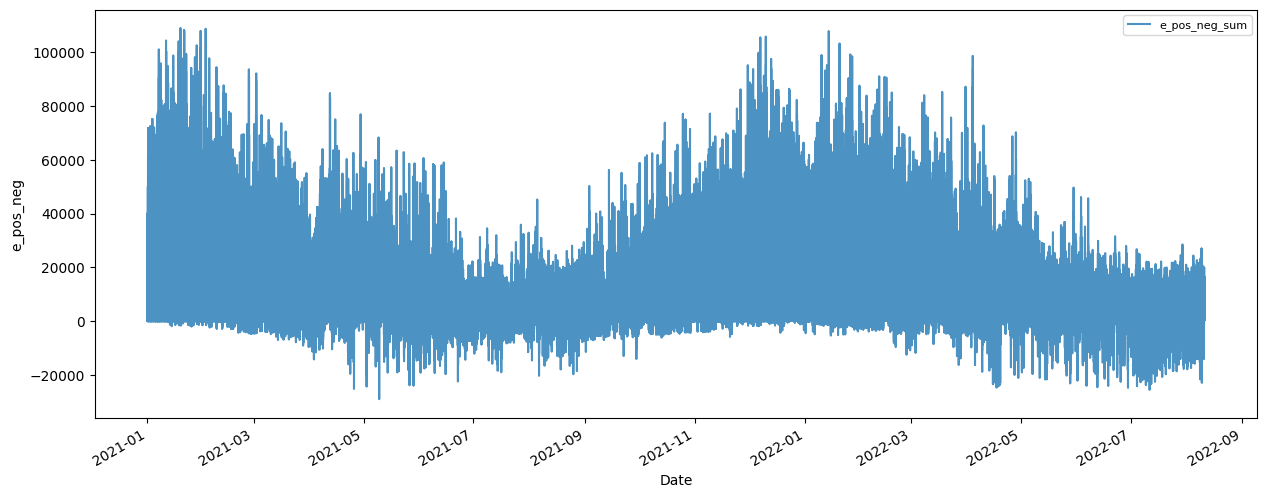

In [81]:
# Visualize target features before outlier detection
# Plot the e_pos_neg_N measures in the df_tr dataset
e_pos_neg_cols = [col for col in df_tr.columns if 'e_pos_neg' in col]

# Plot the e_pos_neg_N columns against the DataFrame's index (which is now the 'Date' column)
df_tr[e_pos_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('e_pos_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

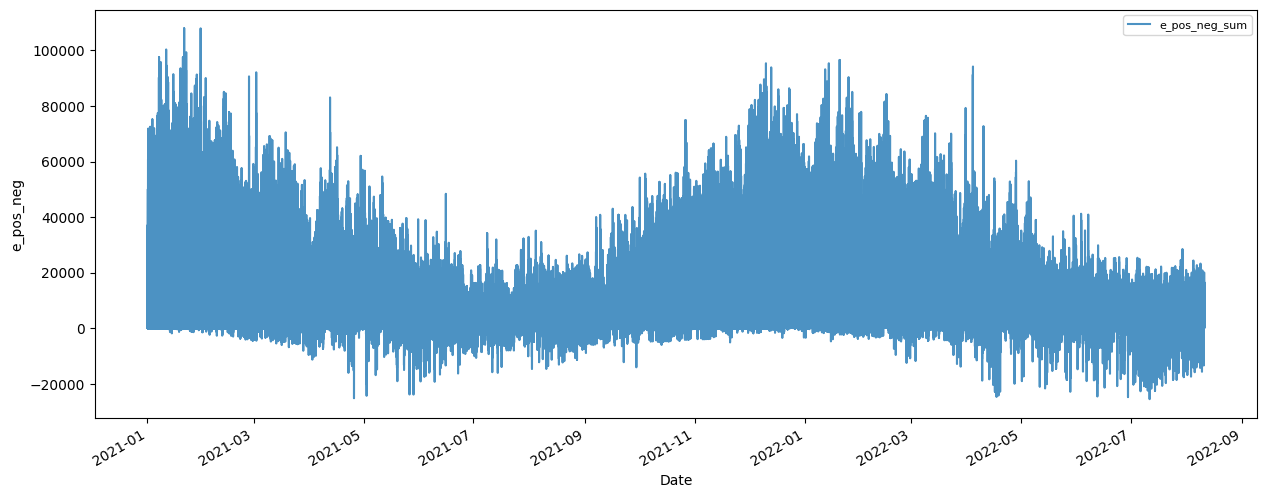

In [82]:
# Visualize target features after outlier detection
# Plot the e_pos_neg_N measures in the capped_df_tr dataset
e_pos_neg_cols = [col for col in capped_df_train.columns if 'e_pos_neg' in col]

# Plot the e_pos_neg_N columns against the DataFrame's index (which is now the 'Date' column)
capped_df_train[e_pos_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('e_pos_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [83]:
# Assigned the cleaned version of df_train
df_train = capped_df_train

## Standardize the data

In [84]:
# target_features = [[f'e_pos_neg_sum_{i}' for i in range(19)], 'PCC_batt_sum']

# # Scale the train_data (except the target features)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train_data = scaler.fit_transform(df_tr.drop(columns=target_features))

# # Scale the test_data (except the target features)
# scaled_test_data = scaler.transform(df_te.drop(columns=target_features)


# # Define a scaler for the target features for being able to reverse the operation later
# label_scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train_label = label_scaler.fit_transform(df_tr.loc[target_features])

# # Scale the test_data (except the target features)
# scaled_test_label = label_scaler.transform(df_te.loc[target_features])

# Data Exploration after cleaning

In [85]:
# Add a new column with the mean of the stations' values to perform stationarity and other checks
e_pos_neg_cols = [col for col in df_nc.columns if 'e_pos_neg_sum' in col]
df_nc['mean_e_pos_neg_sum'] = df_nc[e_pos_neg_cols].mean(axis=1)

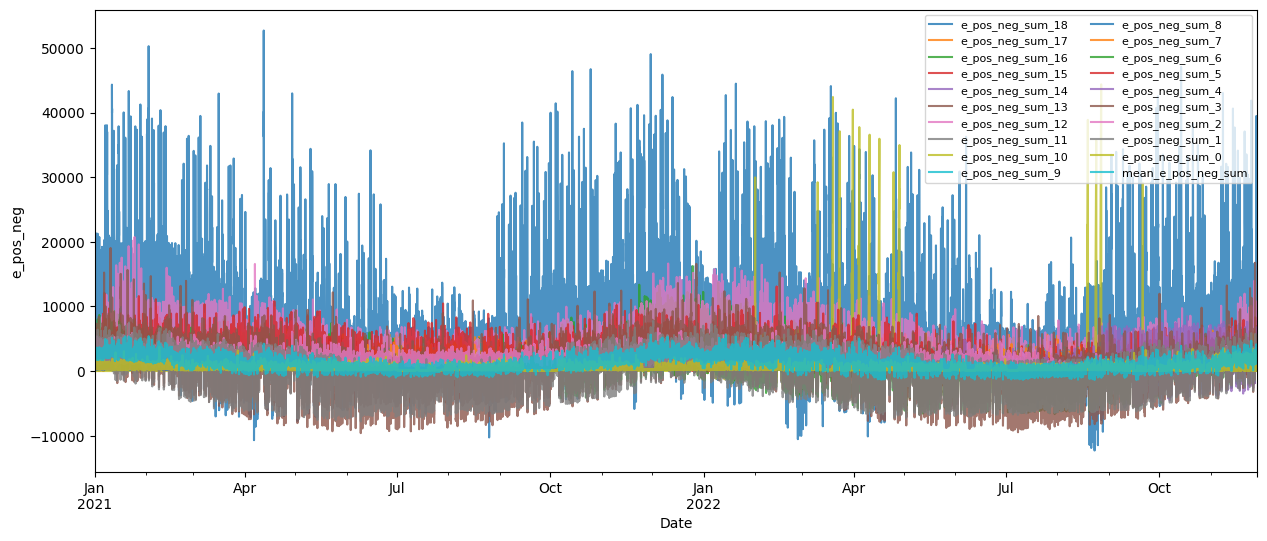

In [86]:
# Set the 'Date' column as the index of the DataFrame
df_nc.set_index('Date', inplace=True)

# Plot the e_pos_neg_N measures in the df_nc dataset
e_pos_neg_cols = [col for col in df_nc.columns if 'e_pos_neg' in col]

# Plot the e_pos_neg_N columns against the DataFrame's index (which is now the 'Date' column)
df_nc[e_pos_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('e_pos_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

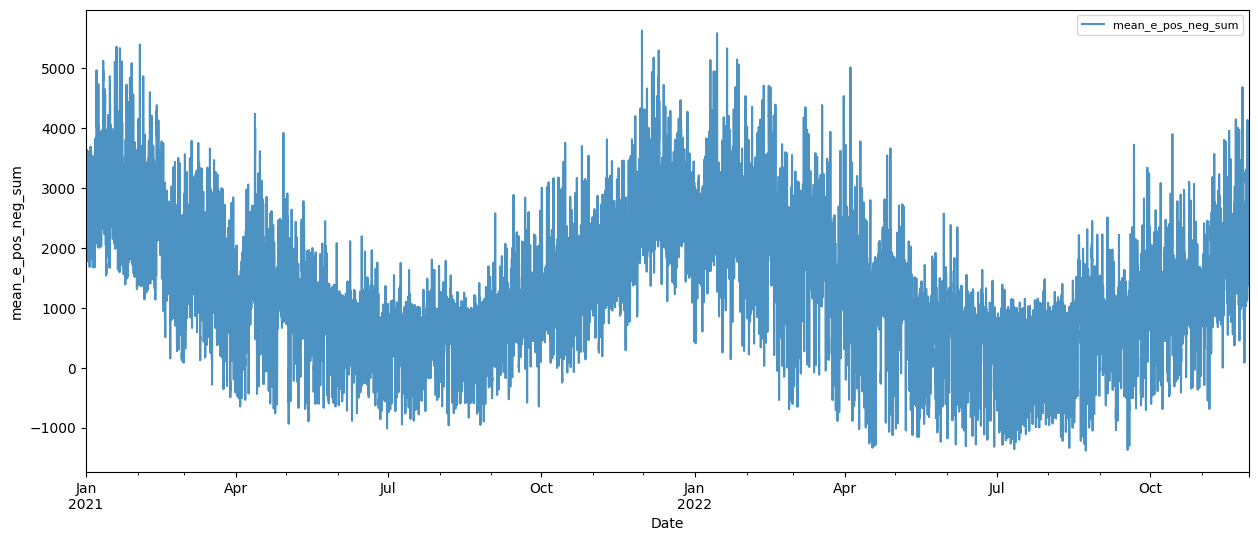

In [87]:
# Plot the mean_e_pos_neg_sum column against the DataFrame's index (which is now the 'Date' column)
df_nc['mean_e_pos_neg_sum'].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('mean_e_pos_neg_sum')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

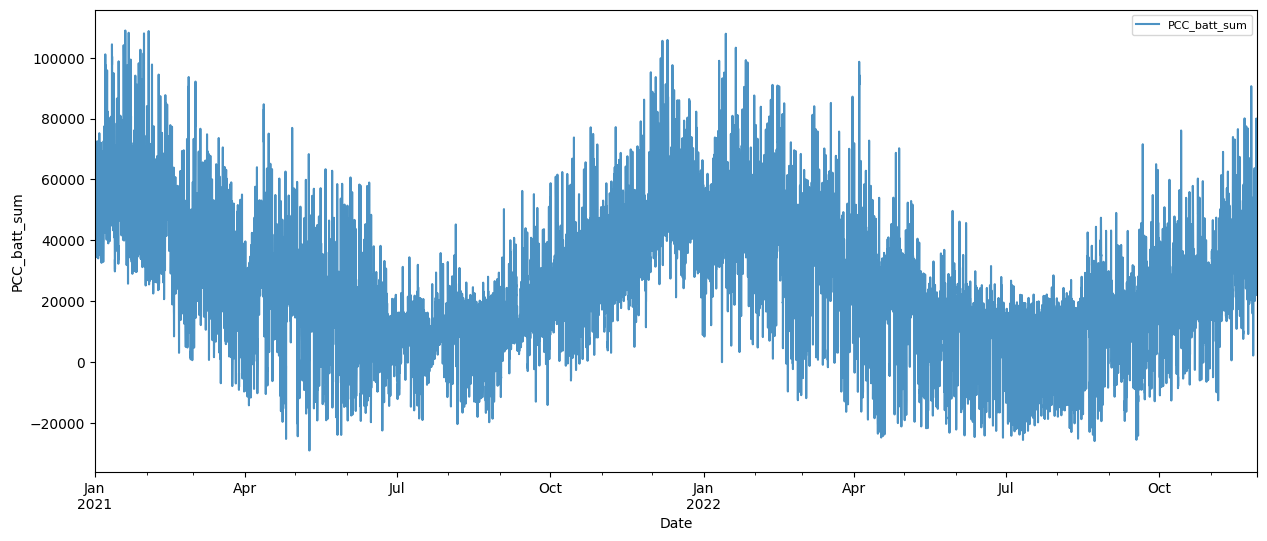

In [88]:
# Plot the PCC_batt_sum column against the DataFrame's index (which is now the 'Date' column)
df_nc['PCC_batt_sum'].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Date')  # Update the x-axis label
plt.ylabel('PCC_batt_sum')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

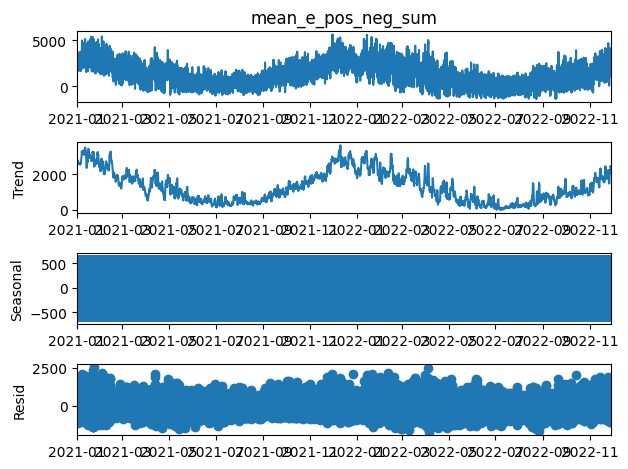

In [89]:
# Decompose the time series of mean_e_pos_neg_sum into trend, seasonality, and residual components
seasonal_period=24
result = seasonal_decompose(df_nc['mean_e_pos_neg_sum'], model='additive', period=seasonal_period) 
result.plot() 
plt.show()

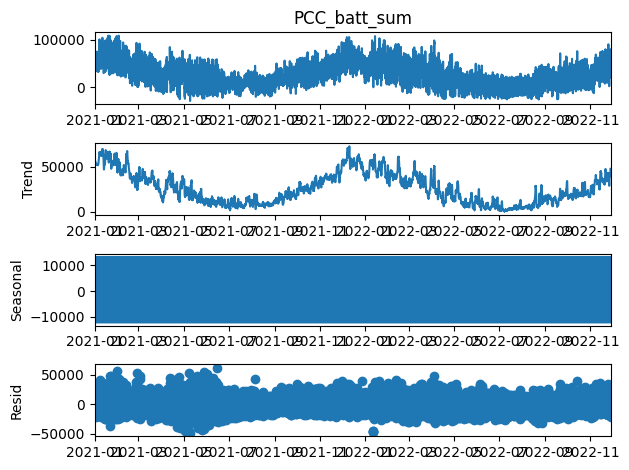

In [90]:
# Decompose the time series of PCC_batt_sum into trend, seasonality, and residual components
result = seasonal_decompose(df_nc['PCC_batt_sum'], model='additive', period=seasonal_period)
result.plot()
plt.show()

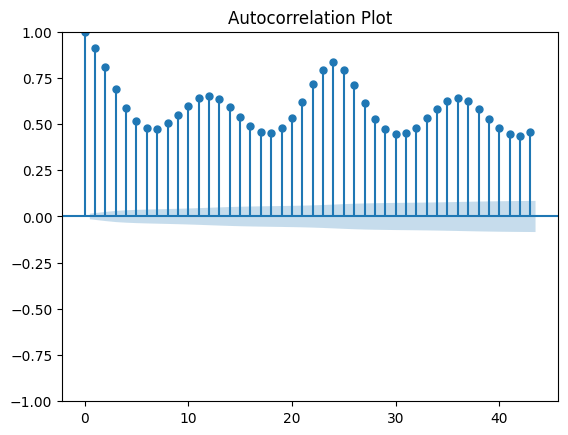

In [106]:
# Plot the autocorrelation function of mean_e_pos_neg_sum
plot_acf(df_nc['mean_e_pos_neg_sum'])
plt.title('Autocorrelation Plot')
plt.show()

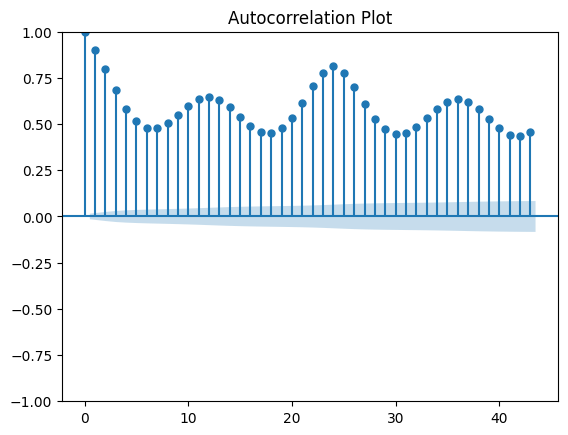

In [107]:
# Plot the autocorrelation function of PCC_batt_sum
plot_acf(df_nc['PCC_batt_sum'])
plt.title('Autocorrelation Plot')
plt.show()

In [108]:
# Perform the Augmented Dickey-Fuller test for stationarity on mean_e_pos_neg_sum
adf_test = sm.tsa.adfuller(df_nc['mean_e_pos_neg_sum'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

# The ADF statistic value of -4.1671377205629 is more negative than the critical values, indicating a strong rejection of the null hypothesis.
#The p-value of 0.0007485726703005352 is very small, providing strong evidence against the null hypothesis.
#Since the ADF statistic is more negative than the critical values and the p-value is small, we can conclude that the time series is stationary at a high confidence level.

# We are not convinced by these results. these functions seem to result often stationarity.

ADF Statistic: -4.1671377205629
p-value: 0.0007485726703005352
Critical Values: {'1%': -3.4307420576980996, '5%': -2.861713273825104, '10%': -2.566862229252193}


In [109]:
# Perform the Augmented Dickey-Fuller test for stationarity on PCC_batt_sum
adf_test = sm.tsa.adfuller(df_nc['PCC_batt_sum'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -4.297996899727046
p-value: 0.0004477737170009717
Critical Values: {'1%': -3.4307420576980996, '5%': -2.861713273825104, '10%': -2.566862229252193}


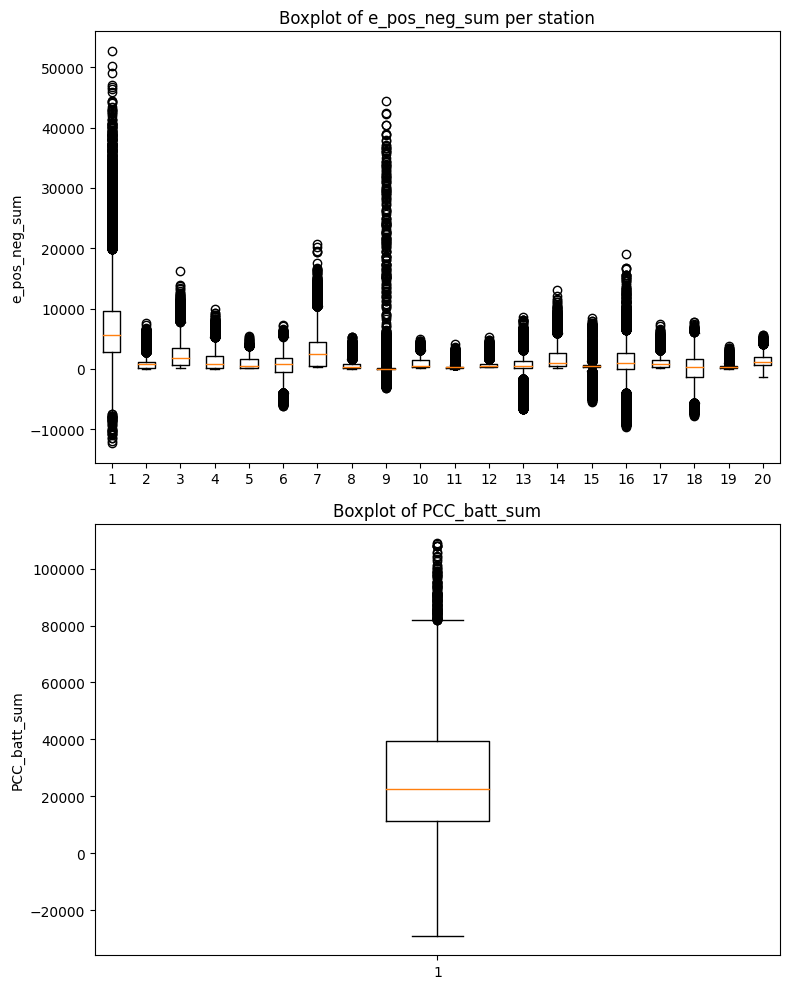

In [110]:
# Plot some boxplots of the target features
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Create a boxplot for mean_e_pos_neg_sum
axes[0].boxplot(df_nc[e_pos_neg_cols])
axes[0].set_ylabel('e_pos_neg_sum')
axes[0].set_title('Boxplot of e_pos_neg_sum per station')

# Create a boxplot for PCC_batt_sum
axes[1].boxplot(df_nc['PCC_batt_sum'])
axes[1].set_ylabel('PCC_batt_sum')
axes[1].set_title('Boxplot of PCC_batt_sum')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

# Feature Selection (if needed)

In [114]:
# Make sure both the datasets have Date as index
#df.set_index('Date', inplace=True)

In [115]:
# Make sure all the features have float values
df = df.astype(float)
df_nc = df_nc.astype(float)

In [116]:
df.columns

Index(['station_id', 'e_pos_neg_sum', 'AirPressure', 'AirTemp_Avg',
       'PyrIrradiance_Avg', 'Ramount_Tot', 'RelHumidity', 'WindSpeed',
       '0_ghi_backwards', '1_ghi_backwards', '2_ghi_backwards',
       '3_ghi_backwards', '4_ghi_backwards', '5_ghi_backwards',
       '6_ghi_backwards', '7_ghi_backwards', '8_ghi_backwards',
       '9_ghi_backwards', '10_ghi_backwards', '11_ghi_backwards',
       '12_ghi_backwards', '13_ghi_backwards', '14_ghi_backwards',
       '15_ghi_backwards', '16_ghi_backwards', '17_ghi_backwards',
       '18_ghi_backwards', '19_ghi_backwards', '20_ghi_backwards',
       '21_ghi_backwards', '22_ghi_backwards', '23_ghi_backwards',
       '0_temperature', '1_temperature', '2_temperature', '3_temperature',
       '4_temperature', '5_temperature', '6_temperature', '7_temperature',
       '8_temperature', '9_temperature', '10_temperature', '11_temperature',
       '12_temperature', '13_temperature', '14_temperature', '15_temperature',
       '16_temperature', '17_

In [117]:
df_nc.columns[:40]

Index(['e_pos_neg_sum_18', 'e_pos_neg_sum_17', 'e_pos_neg_sum_16',
       'e_pos_neg_sum_15', 'e_pos_neg_sum_14', 'e_pos_neg_sum_13',
       'e_pos_neg_sum_12', 'e_pos_neg_sum_11', 'e_pos_neg_sum_10',
       'e_pos_neg_sum_9', 'e_pos_neg_sum_8', 'e_pos_neg_sum_7',
       'e_pos_neg_sum_6', 'e_pos_neg_sum_5', 'e_pos_neg_sum_4',
       'e_pos_neg_sum_3', 'e_pos_neg_sum_2', 'e_pos_neg_sum_1',
       'e_pos_neg_sum_0', 'PCC_batt_sum', 'AirPressure', 'AirTemp_Avg',
       'PyrIrradiance_Avg', 'Ramount_Tot', 'RelHumidity', 'WindSpeed',
       '0_ghi_backwards', '1_ghi_backwards', '2_ghi_backwards',
       '3_ghi_backwards', '4_ghi_backwards', '5_ghi_backwards',
       '6_ghi_backwards', '7_ghi_backwards', '8_ghi_backwards',
       '9_ghi_backwards', '10_ghi_backwards', '11_ghi_backwards',
       '12_ghi_backwards', '13_ghi_backwards'],
      dtype='object')

# Models building

- It is a good idea to train one model for the prediction on the data in ec_meters and another model for PCC as it has a different scale. Otherwise, 21 model (20 stations + PCC) could be made, but it is unnecessary and time consuming.
- Add some base line models

## Split the dataset

## Univariate Linear Forecaster

In [100]:
# Define the LinearForecaster model
class LinearForecaster:
    def __init__(self):
        self.theta = None
        self.target_cols = None

    def fit(self, X, y):
        self.target_cols = y.columns
        self.theta = np.linalg.pinv(X.values.T@X.values)@(X.values.T@y.values)
        return self
    
    def predict(self, X):
        preds = X.values @ self.theta
        return pd.DataFrame(preds, index=X.index, columns=self.target_cols)       

In [101]:
def get_hankel(df, embedding=3):
    dfs = {}
    for c in df.columns:
        df_i = pd.concat([df[[c]].shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]
        df_i.columns = [i for i in range(df_i.shape[1])]
        dfs[c] = df_i
    return pd.concat(dfs, axis=1)

In [102]:
# Compute training and testing sets

train_period = 24*5  # Train on 5 days
tr_ratio = 0.75
n_stations = 19+1 # 19 stations + 1 for the sum of all stations

forecast_periods = [train_period-i for i in range(1, 25)]
period_name = ['1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h']

train_test_splits = {}
linear_univariate_ds = np.ndarray(n_stations, dtype=object)

for i in range(n_stations):
    if i == 19:
        df_l = pd.DataFrame(df_nc[f'PCC_batt_sum'])
    else:
        df_l = pd.DataFrame(df_nc[f'e_pos_neg_sum_{i}'])
    for f_period_name, forecast_period in zip(period_name, forecast_periods):
        df_emb = get_hankel(df_l, embedding = train_period)
        x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
        y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]

        n_tr = int(len(x) * tr_ratio)
        X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
        y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

        train_test_splits[f'{f_period_name}'] = [X_train, y_train, X_test, y_test]
    linear_univariate_ds[i] = train_test_splits

In [103]:
# Train multiple Linear regresssion models on the different datasets, and save results

nmae = lambda y, y_hat: np.sum(np.abs(y_hat-y), axis=0)/np.sum(np.abs(y), axis=0)

scores = {}
linear_univariate_scores = np.ndarray(n_stations, dtype=object)

for i in range(n_stations):
    train_test_splits = linear_univariate_ds[i]
    for split_name, train_test in train_test_splits.items():
        # Train a linear regression model
        lr = LinearForecaster()
        lr.fit(train_test[0], train_test[1])
        y_train_pred_lr = lr.predict(train_test[0])
        y_test_pred_lr = lr.predict(train_test[2])

        # List of scores, in order: [RMSE, R2, NMAE]
        score_string = f'Linear {split_name}'

        scores[score_string] = [mean_squared_error(train_test[3], y_test_pred_lr, squared=False), 
                                            r2_score(train_test[3], y_test_pred_lr), nmae(train_test[3], y_test_pred_lr).mean()]

        # Print results for the different models
        print(f'Station {i}, {split_name} scores:')
        print(f'Training RMSE: {mean_squared_error(train_test[1], y_train_pred_lr, squared=False):.2f}')
        print(f'Testing RMSE: {scores[f"{score_string}"][0]:.2f}')
        print(f'Training R2: {r2_score(train_test[1], y_train_pred_lr):.2f}')
        print(f'Testing R2: {scores[f"{score_string}"][1]:.2f}')
        print(f'Training mean NMAE: {nmae(train_test[1], y_train_pred_lr).mean():0.2e}')
        print('Testing mean NMAE: {:0.2e}'.format(nmae(train_test[3], y_test_pred_lr).mean()))
        print('-'*50, '\n')
    linear_univariate_scores[i] = scores # The score for the PCC is the last one in the list

Station 0, 1h scores:
Training RMSE: 7809.25
Testing RMSE: 6082.07
Training R2: 0.87
Testing R2: 0.86
Training mean NMAE: 1.82e-01
Testing mean NMAE: 2.35e-01
-------------------------------------------------- 

Station 0, 2h scores:
Training RMSE: 8482.70
Testing RMSE: 6774.14
Training R2: 0.84
Testing R2: 0.83
Training mean NMAE: 1.99e-01
Testing mean NMAE: 2.59e-01
-------------------------------------------------- 

Station 0, 3h scores:
Training RMSE: 8966.26
Testing RMSE: 7277.70
Training R2: 0.82
Testing R2: 0.80
Training mean NMAE: 2.11e-01
Testing mean NMAE: 2.76e-01
-------------------------------------------------- 

Station 0, 4h scores:
Training RMSE: 9321.77
Testing RMSE: 7651.55
Training R2: 0.81
Testing R2: 0.78
Training mean NMAE: 2.20e-01
Testing mean NMAE: 2.88e-01
-------------------------------------------------- 

Station 0, 5h scores:
Training RMSE: 9581.29
Testing RMSE: 7920.69
Training R2: 0.80
Testing R2: 0.77
Training mean NMAE: 2.26e-01
Testing mean NMAE: 2.

Station 1, 19h scores:
Training RMSE: 10620.37
Testing RMSE: 8976.85
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.51e-01
Testing mean NMAE: 3.35e-01
-------------------------------------------------- 

Station 1, 20h scores:
Training RMSE: 10643.20
Testing RMSE: 8996.01
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.52e-01
Testing mean NMAE: 3.35e-01
-------------------------------------------------- 

Station 1, 21h scores:
Training RMSE: 10663.91
Testing RMSE: 9013.66
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.52e-01
Testing mean NMAE: 3.36e-01
-------------------------------------------------- 

Station 1, 22h scores:
Training RMSE: 10682.96
Testing RMSE: 9029.73
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.53e-01
Testing mean NMAE: 3.36e-01
-------------------------------------------------- 

Station 1, 23h scores:
Training RMSE: 10701.59
Testing RMSE: 9044.67
Training R2: 0.75
Testing R2: 0.69
Training mean NMAE: 2.53e-01
Testing mea

Testing mean NMAE: 3.28e-01
-------------------------------------------------- 

Station 3, 14h scores:
Training RMSE: 10462.91
Testing RMSE: 8835.98
Training R2: 0.76
Testing R2: 0.71
Training mean NMAE: 2.47e-01
Testing mean NMAE: 3.30e-01
-------------------------------------------------- 

Station 3, 15h scores:
Training RMSE: 10502.37
Testing RMSE: 8873.54
Training R2: 0.76
Testing R2: 0.71
Training mean NMAE: 2.48e-01
Testing mean NMAE: 3.31e-01
-------------------------------------------------- 

Station 3, 16h scores:
Training RMSE: 10536.94
Testing RMSE: 8904.55
Training R2: 0.76
Testing R2: 0.70
Training mean NMAE: 2.49e-01
Testing mean NMAE: 3.32e-01
-------------------------------------------------- 

Station 3, 17h scores:
Training RMSE: 10567.76
Testing RMSE: 8931.74
Training R2: 0.76
Testing R2: 0.70
Training mean NMAE: 2.50e-01
Testing mean NMAE: 3.33e-01
-------------------------------------------------- 

Station 3, 18h scores:
Training RMSE: 10595.46
Testing RMSE: 89

Station 5, 7h scores:
Training RMSE: 9938.15
Testing RMSE: 8292.12
Training R2: 0.78
Testing R2: 0.74
Training mean NMAE: 2.35e-01
Testing mean NMAE: 3.11e-01
-------------------------------------------------- 

Station 5, 8h scores:
Training RMSE: 10061.23
Testing RMSE: 8421.04
Training R2: 0.78
Testing R2: 0.74
Training mean NMAE: 2.38e-01
Testing mean NMAE: 3.15e-01
-------------------------------------------------- 

Station 5, 9h scores:
Training RMSE: 10160.70
Testing RMSE: 8525.61
Training R2: 0.77
Testing R2: 0.73
Training mean NMAE: 2.40e-01
Testing mean NMAE: 3.19e-01
-------------------------------------------------- 

Station 5, 10h scores:
Training RMSE: 10241.81
Testing RMSE: 8610.73
Training R2: 0.77
Testing R2: 0.72
Training mean NMAE: 2.42e-01
Testing mean NMAE: 3.22e-01
-------------------------------------------------- 

Station 5, 11h scores:
Training RMSE: 10309.59
Testing RMSE: 8681.28
Training R2: 0.77
Testing R2: 0.72
Training mean NMAE: 2.44e-01
Testing mean NM

Station 7, 1h scores:
Training RMSE: 7809.25
Testing RMSE: 6082.07
Training R2: 0.87
Testing R2: 0.86
Training mean NMAE: 1.82e-01
Testing mean NMAE: 2.35e-01
-------------------------------------------------- 

Station 7, 2h scores:
Training RMSE: 8482.70
Testing RMSE: 6774.14
Training R2: 0.84
Testing R2: 0.83
Training mean NMAE: 1.99e-01
Testing mean NMAE: 2.59e-01
-------------------------------------------------- 

Station 7, 3h scores:
Training RMSE: 8966.26
Testing RMSE: 7277.70
Training R2: 0.82
Testing R2: 0.80
Training mean NMAE: 2.11e-01
Testing mean NMAE: 2.76e-01
-------------------------------------------------- 

Station 7, 4h scores:
Training RMSE: 9321.77
Testing RMSE: 7651.55
Training R2: 0.81
Testing R2: 0.78
Training mean NMAE: 2.20e-01
Testing mean NMAE: 2.88e-01
-------------------------------------------------- 

Station 7, 5h scores:
Training RMSE: 9581.29
Testing RMSE: 7920.69
Training R2: 0.80
Testing R2: 0.77
Training mean NMAE: 2.26e-01
Testing mean NMAE: 2.

Testing mean NMAE: 3.35e-01
-------------------------------------------------- 

Station 8, 20h scores:
Training RMSE: 10643.20
Testing RMSE: 8996.01
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.52e-01
Testing mean NMAE: 3.35e-01
-------------------------------------------------- 

Station 8, 21h scores:
Training RMSE: 10663.91
Testing RMSE: 9013.66
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.52e-01
Testing mean NMAE: 3.36e-01
-------------------------------------------------- 

Station 8, 22h scores:
Training RMSE: 10682.96
Testing RMSE: 9029.73
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.53e-01
Testing mean NMAE: 3.36e-01
-------------------------------------------------- 

Station 8, 23h scores:
Training RMSE: 10701.59
Testing RMSE: 9044.67
Training R2: 0.75
Testing R2: 0.69
Training mean NMAE: 2.53e-01
Testing mean NMAE: 3.37e-01
-------------------------------------------------- 

Station 8, 24h scores:
Training RMSE: 10722.62
Testing RMSE: 90

Training mean NMAE: 2.46e-01
Testing mean NMAE: 3.28e-01
-------------------------------------------------- 

Station 10, 14h scores:
Training RMSE: 10462.91
Testing RMSE: 8835.98
Training R2: 0.76
Testing R2: 0.71
Training mean NMAE: 2.47e-01
Testing mean NMAE: 3.30e-01
-------------------------------------------------- 

Station 10, 15h scores:
Training RMSE: 10502.37
Testing RMSE: 8873.54
Training R2: 0.76
Testing R2: 0.71
Training mean NMAE: 2.48e-01
Testing mean NMAE: 3.31e-01
-------------------------------------------------- 

Station 10, 16h scores:
Training RMSE: 10536.94
Testing RMSE: 8904.55
Training R2: 0.76
Testing R2: 0.70
Training mean NMAE: 2.49e-01
Testing mean NMAE: 3.32e-01
-------------------------------------------------- 

Station 10, 17h scores:
Training RMSE: 10567.76
Testing RMSE: 8931.74
Training R2: 0.76
Testing R2: 0.70
Training mean NMAE: 2.50e-01
Testing mean NMAE: 3.33e-01
-------------------------------------------------- 

Station 10, 18h scores:
Traini

Station 12, 8h scores:
Training RMSE: 10061.23
Testing RMSE: 8421.04
Training R2: 0.78
Testing R2: 0.74
Training mean NMAE: 2.38e-01
Testing mean NMAE: 3.15e-01
-------------------------------------------------- 

Station 12, 9h scores:
Training RMSE: 10160.70
Testing RMSE: 8525.61
Training R2: 0.77
Testing R2: 0.73
Training mean NMAE: 2.40e-01
Testing mean NMAE: 3.19e-01
-------------------------------------------------- 

Station 12, 10h scores:
Training RMSE: 10241.81
Testing RMSE: 8610.73
Training R2: 0.77
Testing R2: 0.72
Training mean NMAE: 2.42e-01
Testing mean NMAE: 3.22e-01
-------------------------------------------------- 

Station 12, 11h scores:
Training RMSE: 10309.59
Testing RMSE: 8681.28
Training R2: 0.77
Testing R2: 0.72
Training mean NMAE: 2.44e-01
Testing mean NMAE: 3.25e-01
-------------------------------------------------- 

Station 12, 12h scores:
Training RMSE: 10367.56
Testing RMSE: 8741.25
Training R2: 0.76
Testing R2: 0.72
Training mean NMAE: 2.45e-01
Testing 

Station 14, 2h scores:
Training RMSE: 8482.70
Testing RMSE: 6774.14
Training R2: 0.84
Testing R2: 0.83
Training mean NMAE: 1.99e-01
Testing mean NMAE: 2.59e-01
-------------------------------------------------- 

Station 14, 3h scores:
Training RMSE: 8966.26
Testing RMSE: 7277.70
Training R2: 0.82
Testing R2: 0.80
Training mean NMAE: 2.11e-01
Testing mean NMAE: 2.76e-01
-------------------------------------------------- 

Station 14, 4h scores:
Training RMSE: 9321.77
Testing RMSE: 7651.55
Training R2: 0.81
Testing R2: 0.78
Training mean NMAE: 2.20e-01
Testing mean NMAE: 2.88e-01
-------------------------------------------------- 

Station 14, 5h scores:
Training RMSE: 9581.29
Testing RMSE: 7920.69
Training R2: 0.80
Testing R2: 0.77
Training mean NMAE: 2.26e-01
Testing mean NMAE: 2.98e-01
-------------------------------------------------- 

Station 14, 6h scores:
Training RMSE: 9782.58
Testing RMSE: 8128.27
Training R2: 0.79
Testing R2: 0.75
Training mean NMAE: 2.31e-01
Testing mean NMA

Training mean NMAE: 2.51e-01
Testing mean NMAE: 3.35e-01
-------------------------------------------------- 

Station 15, 20h scores:
Training RMSE: 10643.20
Testing RMSE: 8996.01
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.52e-01
Testing mean NMAE: 3.35e-01
-------------------------------------------------- 

Station 15, 21h scores:
Training RMSE: 10663.91
Testing RMSE: 9013.66
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.52e-01
Testing mean NMAE: 3.36e-01
-------------------------------------------------- 

Station 15, 22h scores:
Training RMSE: 10682.96
Testing RMSE: 9029.73
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.53e-01
Testing mean NMAE: 3.36e-01
-------------------------------------------------- 

Station 15, 23h scores:
Training RMSE: 10701.59
Testing RMSE: 9044.67
Training R2: 0.75
Testing R2: 0.69
Training mean NMAE: 2.53e-01
Testing mean NMAE: 3.37e-01
-------------------------------------------------- 

Station 15, 24h scores:
Traini

Station 17, 14h scores:
Training RMSE: 10462.91
Testing RMSE: 8835.98
Training R2: 0.76
Testing R2: 0.71
Training mean NMAE: 2.47e-01
Testing mean NMAE: 3.30e-01
-------------------------------------------------- 

Station 17, 15h scores:
Training RMSE: 10502.37
Testing RMSE: 8873.54
Training R2: 0.76
Testing R2: 0.71
Training mean NMAE: 2.48e-01
Testing mean NMAE: 3.31e-01
-------------------------------------------------- 

Station 17, 16h scores:
Training RMSE: 10536.94
Testing RMSE: 8904.55
Training R2: 0.76
Testing R2: 0.70
Training mean NMAE: 2.49e-01
Testing mean NMAE: 3.32e-01
-------------------------------------------------- 

Station 17, 17h scores:
Training RMSE: 10567.76
Testing RMSE: 8931.74
Training R2: 0.76
Testing R2: 0.70
Training mean NMAE: 2.50e-01
Testing mean NMAE: 3.33e-01
-------------------------------------------------- 

Station 17, 18h scores:
Training RMSE: 10595.46
Testing RMSE: 8955.43
Training R2: 0.75
Testing R2: 0.70
Training mean NMAE: 2.51e-01
Testin

Station 19, 9h scores:
Training RMSE: 10160.70
Testing RMSE: 8525.61
Training R2: 0.77
Testing R2: 0.73
Training mean NMAE: 2.40e-01
Testing mean NMAE: 3.19e-01
-------------------------------------------------- 

Station 19, 10h scores:
Training RMSE: 10241.81
Testing RMSE: 8610.73
Training R2: 0.77
Testing R2: 0.72
Training mean NMAE: 2.42e-01
Testing mean NMAE: 3.22e-01
-------------------------------------------------- 

Station 19, 11h scores:
Training RMSE: 10309.59
Testing RMSE: 8681.28
Training R2: 0.77
Testing R2: 0.72
Training mean NMAE: 2.44e-01
Testing mean NMAE: 3.25e-01
-------------------------------------------------- 

Station 19, 12h scores:
Training RMSE: 10367.56
Testing RMSE: 8741.25
Training R2: 0.76
Testing R2: 0.72
Training mean NMAE: 2.45e-01
Testing mean NMAE: 3.27e-01
-------------------------------------------------- 

Station 19, 13h scores:
Training RMSE: 10418.04
Testing RMSE: 8791.99
Training R2: 0.76
Testing R2: 0.71
Training mean NMAE: 2.46e-01
Testing

## Multivariate Linear Forecaster

In [104]:
df_m = df_nc.copy()
df_m.set_index('Date', inplace=True)


# Compute training and testing sets

train_period = 24*5  # Train on 5 days
tr_ratio = 0.75
n_stations = 19+1 # 19 stations + 1 for the sum of all stations

train_test_splits = {}
linear_multivariate_ds = np.ndarray(n_stations, dtype=object)

for i in range(n_stations):
    print(i)
    for f_period_name, forecast_period in zip(period_name, forecast_periods):
        df_emb = get_hankel(df_m, embedding = train_period)

        x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
        x["dayminute"] = np.sin((x.index.hour * 60 + x.index.minute) / (1410) * 2 * np.pi - np.pi)/2
        x["dayofyear"] = x.index.dayofyear / 365

        if i == 19:
            y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]['PCC_batt_sum']
        else:
            y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period][f'e_pos_neg_sum_{i}']

        n_tr = int(len(x) * tr_ratio)
        X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
        y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

        train_test_splits[f'{f_period_name}'] = [X_train, y_train, X_test, y_test]
    linear_multivariate_ds[i] = train_test_splits

KeyError: "None of ['Date'] are in the columns"

In [ ]:
# Train multivariate Linear regression model on the stations
scores = {}
linear_multivariate_models = np.ndarray((n_stations,24), dtype=object)
linear_multivariate_scores = np.ndarray(n_stations, dtype=object)

for i in range(n_stations):
    train_test_splits = linear_univariate_ds[i]
    h = 0
    for split_name, train_test in train_test_splits.items():
        # Train a linear regression model
        lr = LinearForecaster()
        lr.fit(train_test[0], train_test[1])
        y_train_pred_lr = lr.predict(train_test[0])
        y_test_pred_lr = lr.predict(train_test[2])

        linear_multivariate_models[i, h] = lr
        h += 1

        # List of scores, in order: [RMSE, R2, NMAE]
        score_string = f'Linear {split_name}'

        scores[score_string] = [mean_squared_error(train_test[3], y_test_pred_lr, squared=False), 
                                            r2_score(train_test[3], y_test_pred_lr), nmae(train_test[3], y_test_pred_lr).mean()]

        # Print results for the different models
        print(f'Station {i}, {split_name} scores:')
        print(f'Training RMSE: {mean_squared_error(train_test[1], y_train_pred_lr, squared=False):.2f}')
        print(f'Testing RMSE: {scores[f"{score_string}"][0]:.2f}')
        print(f'Training R2: {r2_score(train_test[1], y_train_pred_lr):.2f}')
        print(f'Testing R2: {scores[f"{score_string}"][1]:.2f}')
        print(f'Training mean NMAE: {nmae(train_test[1], y_train_pred_lr).mean():0.2e}')
        print('Testing mean NMAE: {:0.2e}'.format(nmae(train_test[3], y_test_pred_lr).mean()))
        print('-'*50, '\n')
    linear_multivariate_scores[i] = scores # The score for the PCC is the last one in the list

In [ ]:
for i in range(n_stations):
    with open(Path(data_path, f'linear_multi_models\lm_{i}.pkl'), 'wb') as handle:
        pickle.dump(linear_multivariate_models[i,:], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
for i in range(n_stations):
    # Load data
    with open(Path(data_path, f'linear_multi_models\lm_{i}.pkl'), 'rb') as handle:
        linear_multivariate_models[i,:] = pickle.load(handle)

## LSTM

In [ ]:
# Reshape the input features for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(2))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=50, verbose=0)

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error: %.3f' % mse)


# Model selection

In [ ]:
# Preprocess the data
# You can apply any additional preprocessing steps based on your dataset's requirements
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[df.columns.levels[0] == 'general'] = scaler.fit_transform(df[df.columns.levels[0] == 'general'])

# Split the data into training and validation sets
train_df, val_df = train_test_split(scaled_df, test_size=0.2, shuffle=False, random_state=42)

# Bottom-up hierarchical modeling
# Train individual models for each station's epos and eneg values
models = {}
for station in df.columns.levels[1]:
    for variable in ['epos', 'eneg']:
        X_train = train_df.loc[:, ('general', 'general')].values
        y_train = train_df.loc[:, (slice(None), station, variable)].values.ravel()

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        models[(station, variable)] = model

# Validate the models on the validation set
X_val = val_df.loc[:, ('general', 'general')].values
y_val_true = val_df.loc[:, (slice(None), slice(None), ['epos', 'eneg'])].values.reshape(-1)
y_val_pred = np.zeros_like(y_val_true)

for i, (station, variable) in enumerate(models.keys()):
    model = models[(station, variable)]
    y_val_pred[i::len(models)] = model.predict(X_val)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val_true, y_val_pred)
print(f'Mean Absolute Error: {mae:.2f}')
